In [1]:
import pandas as pd
import plotly.express as px
from google.colab import drive
import geopandas as gpd
import plotly.express as px
import panel as pn
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract climate data

In [5]:
shp=gpd.read_file("drive/MyDrive/Maharashtra_Climate_Health/2_Data/MH_Taluka_WCD")

In [8]:
shp=shp.dropna(subset=["geometry"])

In [11]:
shp["representative_point"] = shp.geometry.representative_point()


In [13]:
import requests
import pandas as pd
from tqdm import tqdm

start_date = "2025-01-01"
end_date = "2025-06-30"

base_url = "https://customer-archive-api.open-meteo.com/v1/archive"

# Convert list fields to comma-separated strings as required by API
params = {"daily": ["apparent_temperature_mean", "temperature_2m_min", "temperature_2m_mean", "temperature_2m_max", "relative_humidity_2m_mean"],
    "timezone": "Asia/Kolkata",
    "start_date": start_date,
    "end_date": end_date,
    "apikey": "FrBHTVq25VDS9Lfu"
}

all_data = []
session = requests.Session()  # Reuse TCP connection

for idx, row in tqdm(shp.iterrows(), total=len(shp)):
    lat, lon = row.representative_point.y, row.representative_point.x

    try:
        response = session.get(base_url, params={**params, "latitude": lat, "longitude": lon}, timeout=10)
        response.raise_for_status()  # Raise exception for HTTP errors

        data = response.json()
        daily = data.get("daily")

        if daily:
            daily_df = pd.DataFrame(daily)
            daily_df["latitude"] = lat
            daily_df["longitude"] = lon
            daily_df["point_id"] = idx
            daily_df["dtname"] = row["dtname"]
            daily_df["sdtname"] = row["sdtname"]
            all_data.append(daily_df)
        else:
            print(f"No daily data for point {idx} ({lat}, {lon})")

    except Exception as e:
        print(f"Request failed for point {idx} ({lat}, {lon}): {e}")

session.close()

# Combine all data
if all_data:
    weather_df = pd.concat(all_data, ignore_index=True)
else:
    weather_df = pd.DataFrame()


100%|██████████| 359/359 [01:56<00:00,  3.08it/s]


In [14]:
weather_df.drop(columns=["latitude", "longitude"]).to_csv("drive/MyDrive/Maharashtra_Climate_Health/2_Data/Climate/raw/daily_vars_2025-01-01_to_2025-06-30.csv", index=False)

In [ ]:
raw_block=pd.read_csv("drive/MyDrive/CHVI/Maharashtra/data/poshan_climate_block.csv")

In [ ]:
raw=pd.read_csv("drive/MyDrive/CHVI/Maharashtra/data/poshan_climate_month_block.csv")

In [ ]:
for col in raw_block:
  if col not in ['dtname', 'sdtname']:
   print(col, raw_block[col].min(), raw_block[col].max(), raw_block[col].median())

dtcode11 497 732 514.0
sdtcode11 3950 5927 4128.0
Mean Daily Average Temperature (2m) (°C) 19.703995296853627 27.91567162106703 26.590079225718195
Mean Daily Maximum Temperature (2m) (°C) 24.511202191518468 34.38583050889193 32.25221722298222
Mean Daily Minimum Temperature (2m) (°C) 15.814827065663476 24.26210670314637 21.495599321477428
Sum Daily Precipitation (Rain, Showers, Snowfall) (mm) 1444.10001295 7166.30005937 2378.79999935
Sum Daily Rainfall Score (0-5) 150 453 223.0
Number of Heavy & Extremely Rainfall Days 0 4 0.0
Number of Heat Wave Days 0 11 1.0
Number of Severe Heat Wave Days 0 6 0.0
Number of Drought Months 0 1 0.0
Number of Severely Dry Months 0 3 2.0
Number of Moderately Dry Months 0 5 2.0
Number of Near Normal Months 13 18 15.0
Number of Moderately Wet Months 1 6 4.0
Number of Very Wet Months 0 3 2.0
Number of Extremely Wet Months 0 1 0.0
Stunting - Moderate 5060.0 1081586.0 48889.0
Stunting - Severe 4625.0 941099.0 47260.0
Underweight - Moderate 2501.0 830644.0 2956

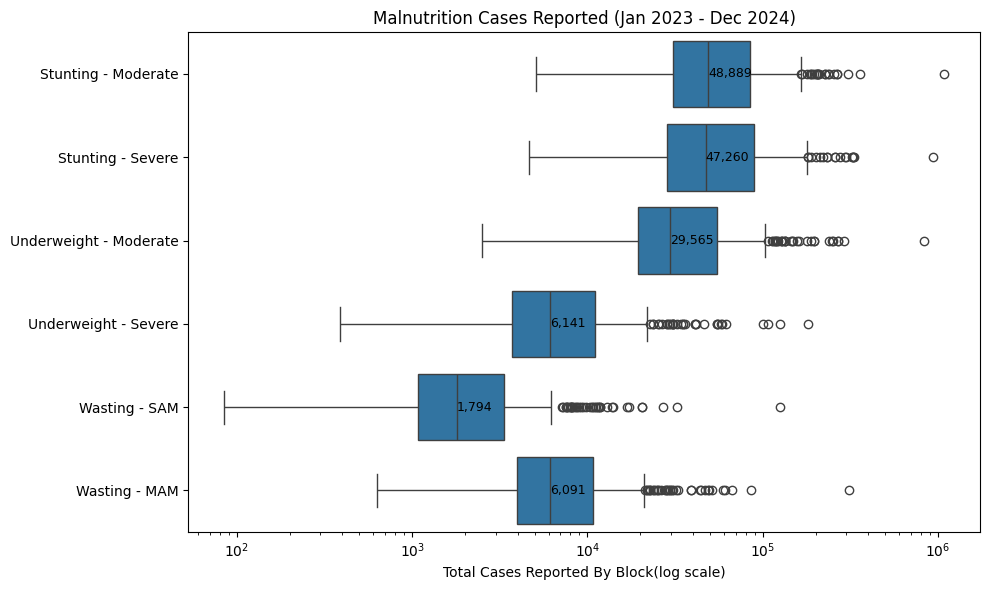

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Indicator columns
indicators = [
    'Stunting - Moderate',
    'Stunting - Severe',
    'Underweight - Moderate',
    'Underweight - Severe',
    'Wasting - SAM',
    'Wasting - MAM'
]

# Melt to long format
df_long = raw_block[indicators].melt(var_name='Indicator', value_name='Cases')
df_long['Cases'] = df_long['Cases'].replace(0, np.nan)  # Avoid log(0)


plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, y='Indicator', x='Cases', orient='h')
plt.xscale('log')
plt.xlabel('Total Cases Reported By Block(log scale)')
plt.ylabel('')
plt.title('Malnutrition Cases Reported (Jan 2023 - Dec 2024)')

# Annotate medians
medians = df_long.groupby('Indicator')['Cases'].median().to_dict()
for idx, indicator in enumerate(ax.get_yticklabels()):
    ind = indicator.get_text()
    median_val = medians[ind]
    ax.text(median_val, idx, f'{int(median_val):,}', color='black', ha='left', va='center', fontsize=9)

# Set up plot

plt.tight_layout()

# plt.savefig(f'{path}/malnutrition_univariate/cases_reporting.png', dpi=300)

plt.show()


#Time period: 01-01-2023 to 01-01-2025, 355 Blocks, 36 Districts

In [ ]:
# var lists

malnutrition_vars = [
    'Stunting - Moderate (Count)', 'Stunting - Severe (Count)',
    'Underweight - Moderate (Count)', 'Underweight - Severe (Count)',
    'Wasting - SAM (Count)', 'Wasting - MAM (Count)'
]

heat_vars = [
    'Mean Average Temperature (2m) (°C)',
    'Mean Average Apparent Temperature (2m) (°C)',
    'Mean Maximum Temperature (2m) (°C)',
    'Mean Minimum Temperature (2m) (°C)',
    'Mean Relative Humidity (2m) (%)',
    'Sum Total Rainfall (mm)',
    'Maximum UV Index'
]



socio_vars = [
      'Category - Minority (%)',
       'Category - OBC (%)', 'Category - SC (%)',
       'Category - ST (%)', 'Gender - Female (%)']

# 1. Bi-variate Spatial + Temporal Correlation Plots - Block-Month

- Independent variables vs malnutrition outcomes

In [ ]:
# Set up folder to save images
os.makedirs(f"{path}/bivariate", exist_ok=True)

In [ ]:
y_vars=heat_vars  + socio_vars

a. Heat & Climate vs Malnutrition

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from base64 import b64encode


images=[]


# -----------------------------
# Heat vs Malnutrition
# -----------------------------
for y_var in y_vars:
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle(f'{y_var} vs Malnutrition Outcomes (By Block-Month, Maharashtra, Jan 2023- Jan 2025)', fontsize=18)

    for i, mal_var in enumerate(malnutrition_vars):
        ax = axes[i // 3, i % 3]
        sns.regplot(data=month_block_df, x=y_var, y=mal_var, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}, ax=ax)
        ax.set_title(f'{mal_var}', fontsize=16)
        ax.set_xlabel(y_var, fontsize=14)
        ax.set_ylabel(mal_var, fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    safe_name = safe_filename(y_var)
    img_path = f"{path}/bivariate/heat_{safe_name}_vs_malnutrition.png"
    plt.savefig(img_path)
    plt.close()
    images.append(img_path)


# -----------------------------
# Create HTML with headings
# -----------------------------
html_content = """
<html>
<head>
    <title>Bi-variate Scatter Plots</title>
</head>
<body>
    <h1 style="text-align:center;">Bi-variate Scatter Plots</h1>

    <h2>Climate, Heat & Socio-economic Variables vs Malnutrition Outcomes</h2>
"""

for img in images:
    with open(img, "rb") as f:
        encoded = b64encode(f.read()).decode("utf-8")
        html_content += f'<h3>{os.path.basename(img)}</h3>'
        html_content += f'<img src="data:image/png;base64,{encoded}" style="max-width:100%;"><hr>'


# Save HTML
with open(f"{path}/bivariate/Malnutrition_vs_Independent_Vars_ScatterPlots.html", "w") as f:
    f.write(html_content)

print("HTML created: Malnutrition_vs_Independent_Vars_ScatterPlots.html")

HTML created: Malnutrition_vs_Independent_Vars_ScatterPlots.html


# 2. Multi-variate heat correlation plots
-  Effect of Heat - avg temp, max temp on malnutrition

a. Mean Average Temperature (2m) (°C), Mean Relative Humidity (2m) (%)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define variables
x_var = 'Mean Average Temperature (2m) (°C)'
y_var = 'Mean Relative Humidity (2m) (%)'
z_vars = [
    'Stunting (%)',
    'Stunting - Moderate (%)',
    'Stunting - Severe (%)',
    'Underweight (%)',
    'Underweight - Moderate (%)',
    'Underweight - Severe (%)',
    'Wasting (%)',
    'Wasting - MAM (%)',
    'Wasting - SAM (%)'
]

# Reshape and normalize
df_long = pd.melt(
    block_df,
    id_vars=['sdtname', x_var, y_var],
    value_vars=z_vars,
    var_name='Malnutrition Type',
    value_name='Value'
)

df_long['Value_Norm'] = df_long.groupby('Malnutrition Type')['Value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Subplots
rows = int(np.ceil(len(z_vars) / 3))
fig = make_subplots(
    rows=rows, cols=3,
    subplot_titles=z_vars,
    horizontal_spacing=0.07,
    vertical_spacing=0.1
)

# Add each subplot
for i, z_var in enumerate(z_vars):
    r = i // 3 + 1
    c = i % 3 + 1
    sub_df = df_long[df_long['Malnutrition Type'] == z_var]

    fig.add_trace(
        go.Scatter(
            x=sub_df[x_var],
            y=sub_df[y_var],
            mode='markers',
            marker=dict(
                size=6,
                color=sub_df['Value_Norm'],
                colorscale='YlOrRd',
                cmin=0,
                cmax=1,
                colorbar=dict(
                    title='Relative Malnutrition Scale (0–1)',
                    x=1.02,
                    len=0.8,
                    titlefont=dict(size=14),
                    tickfont=dict(size=12)
                ) if i == 0 else None
            ),
            text=sub_df['sdtname'],
            hovertemplate=(
                f"<b>%{{text}}</b><br>{x_var}: %{{x}}<br>{y_var}: %{{y}}<br>{z_var}: %{{marker.color:.2f}}<extra></extra>"
            ),
            showlegend=False
        ),
        row=r, col=c
    )

# Update layout and fonts
fig.update_layout(
    height=1100,
    width=1200,
    title=dict(
        text='Effect of Mean Average Temperature & Relative Humidity on Malnutrition Outcomes (By Block, Maharashtra, Jan 2023- Jan 2025)',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    font=dict(size=14),
    margin=dict(t=100, b=80, l=100, r=140)
)

# Shared axes
fig.update_xaxes(title_text=x_var, title_font=dict(size=16), row=rows, col=2)
fig.update_yaxes(title_text=y_var, title_font=dict(size=16), row=2, col=1)

# Save outputs
fig.write_html(f"{path}/multivariate/relative_scale_temperature_humidity_vs_malnutrition.html")
fig.write_image(f"{path}/multivariate/relative_scale_temperature_humidity_vs_malnutrition.jpg", scale=2)


b. Max Avg Temperature, Relative Humidity

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define variables
x_var = 'Mean Maximum Temperature (2m) (°C)'
y_var = 'Mean Relative Humidity (2m) (%)'
z_vars = [
    'Stunting (%)',
    'Stunting - Moderate (%)',
    'Stunting - Severe (%)',
    'Underweight (%)',
    'Underweight - Moderate (%)',
    'Underweight - Severe (%)',
    'Wasting (%)',
    'Wasting - MAM (%)',
    'Wasting - SAM (%)'
]

# Reshape and normalize
df_long = pd.melt(
    block_df,
    id_vars=['sdtname', x_var, y_var],
    value_vars=z_vars,
    var_name='Malnutrition Type',
    value_name='Value'
)

df_long['Value_Norm'] = df_long.groupby('Malnutrition Type')['Value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Subplots
rows = int(np.ceil(len(z_vars) / 3))
fig = make_subplots(
    rows=rows, cols=3,
    subplot_titles=z_vars,
    horizontal_spacing=0.07,
    vertical_spacing=0.1
)

# Add each subplot
for i, z_var in enumerate(z_vars):
    r = i // 3 + 1
    c = i % 3 + 1
    sub_df = df_long[df_long['Malnutrition Type'] == z_var]

    fig.add_trace(
        go.Scatter(
            x=sub_df[x_var],
            y=sub_df[y_var],
            mode='markers',
            marker=dict(
                size=6,
                color=sub_df['Value_Norm'],
                colorscale='YlOrRd',
                cmin=0,
                cmax=1,
                colorbar=dict(
                    title='Relative Malnutrition Scale (0–1)',
                    x=1.02,
                    len=0.8,
                    titlefont=dict(size=14),
                    tickfont=dict(size=12)
                ) if i == 0 else None
            ),
            text=sub_df['sdtname'],
            hovertemplate=(
                f"<b>%{{text}}</b><br>{x_var}: %{{x}}<br>{y_var}: %{{y}}<br>{z_var}: %{{marker.color:.2f}}<extra></extra>"
            ),
            showlegend=False
        ),
        row=r, col=c
    )

# Update layout and fonts
fig.update_layout(
    height=1100,
    width=1200,
    title=dict(
        text='Effect of Mean Maximum Temperature & Relative Humidity on Malnutrition Outcomes (By Block, Maharashtra, Jan 2023- Jan 2025)',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    font=dict(size=14),
    margin=dict(t=100, b=80, l=100, r=140)
)

# Shared axes
fig.update_xaxes(title_text=x_var, title_font=dict(size=16), row=rows, col=2)
fig.update_yaxes(title_text=y_var, title_font=dict(size=16), row=2, col=1)

# Save outputs
fig.write_html(f"{path}/multivariate/relative_scale_max_temperature_humidity_vs_malnutrition.html")
fig.write_image(f"{path}/multivariate/relative_scale_max_temperature_humidity_vs_malnutrition.jpg", scale=2)


c. Avg Apparent Temperature, Humidity

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define variables
x_var =  'Mean Average Apparent Temperature (2m) (°C)'
y_var = 'Mean Relative Humidity (2m) (%)'
z_vars = [
    'Stunting (%)',
    'Stunting - Moderate (%)',
    'Stunting - Severe (%)',
    'Underweight (%)',
    'Underweight - Moderate (%)',
    'Underweight - Severe (%)',
    'Wasting (%)',
    'Wasting - MAM (%)',
    'Wasting - SAM (%)'
]

# Reshape and normalize
df_long = pd.melt(
    block_df,
    id_vars=['sdtname', x_var, y_var],
    value_vars=z_vars,
    var_name='Malnutrition Type',
    value_name='Value'
)

df_long['Value_Norm'] = df_long.groupby('Malnutrition Type')['Value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Subplots
rows = int(np.ceil(len(z_vars) / 3))
fig = make_subplots(
    rows=rows, cols=3,
    subplot_titles=z_vars,
    horizontal_spacing=0.07,
    vertical_spacing=0.1
)

# Add each subplot
for i, z_var in enumerate(z_vars):
    r = i // 3 + 1
    c = i % 3 + 1
    sub_df = df_long[df_long['Malnutrition Type'] == z_var]

    fig.add_trace(
        go.Scatter(
            x=sub_df[x_var],
            y=sub_df[y_var],
            mode='markers',
            marker=dict(
                size=6,
                color=sub_df['Value_Norm'],
                colorscale='YlOrRd',
                cmin=0,
                cmax=1,
                colorbar=dict(
                    title='Relative Malnutrition Scale (0–1)',
                    x=1.02,
                    len=0.8,
                    titlefont=dict(size=14),
                    tickfont=dict(size=12)
                ) if i == 0 else None
            ),
            text=sub_df['sdtname'],
            hovertemplate=(
                f"<b>%{{text}}</b><br>{x_var}: %{{x}}<br>{y_var}: %{{y}}<br>{z_var}: %{{marker.color:.2f}}<extra></extra>"
            ),
            showlegend=False
        ),
        row=r, col=c
    )

# Update layout and fonts
fig.update_layout(
    height=1100,
    width=1200,
    title=dict(
        text='Effect of Mean Average Apparent Temperature & Relative Humidity on Malnutrition Outcomes (By Block, Maharashtra, Jan 2023- Jan 2025)',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    font=dict(size=14),
    margin=dict(t=100, b=80, l=100, r=140)
)

# Shared axes
fig.update_xaxes(title_text=x_var, title_font=dict(size=16), row=rows, col=2)
fig.update_yaxes(title_text=y_var, title_font=dict(size=16), row=2, col=1)

# Save outputs
fig.write_html(f"{path}/multivariate/relative_scale_app_temperature_humidity_vs_malnutrition.html")
fig.write_image(f"{path}/multivariate/relative_scale_app_temperature_humidity_vs_malnutrition.jpg", scale=2)


# Correlation Matrices

In [ ]:
raw.columns

In [ ]:
raw['Number of Heat Wave/Severe Heat Wave Days'] = raw['Number of Heat Wave Days'] + raw['Number of Severe Heat Wave Days']

In [ ]:
raw["month"]=pd.to_datetime(raw["month_year"]).dt.month

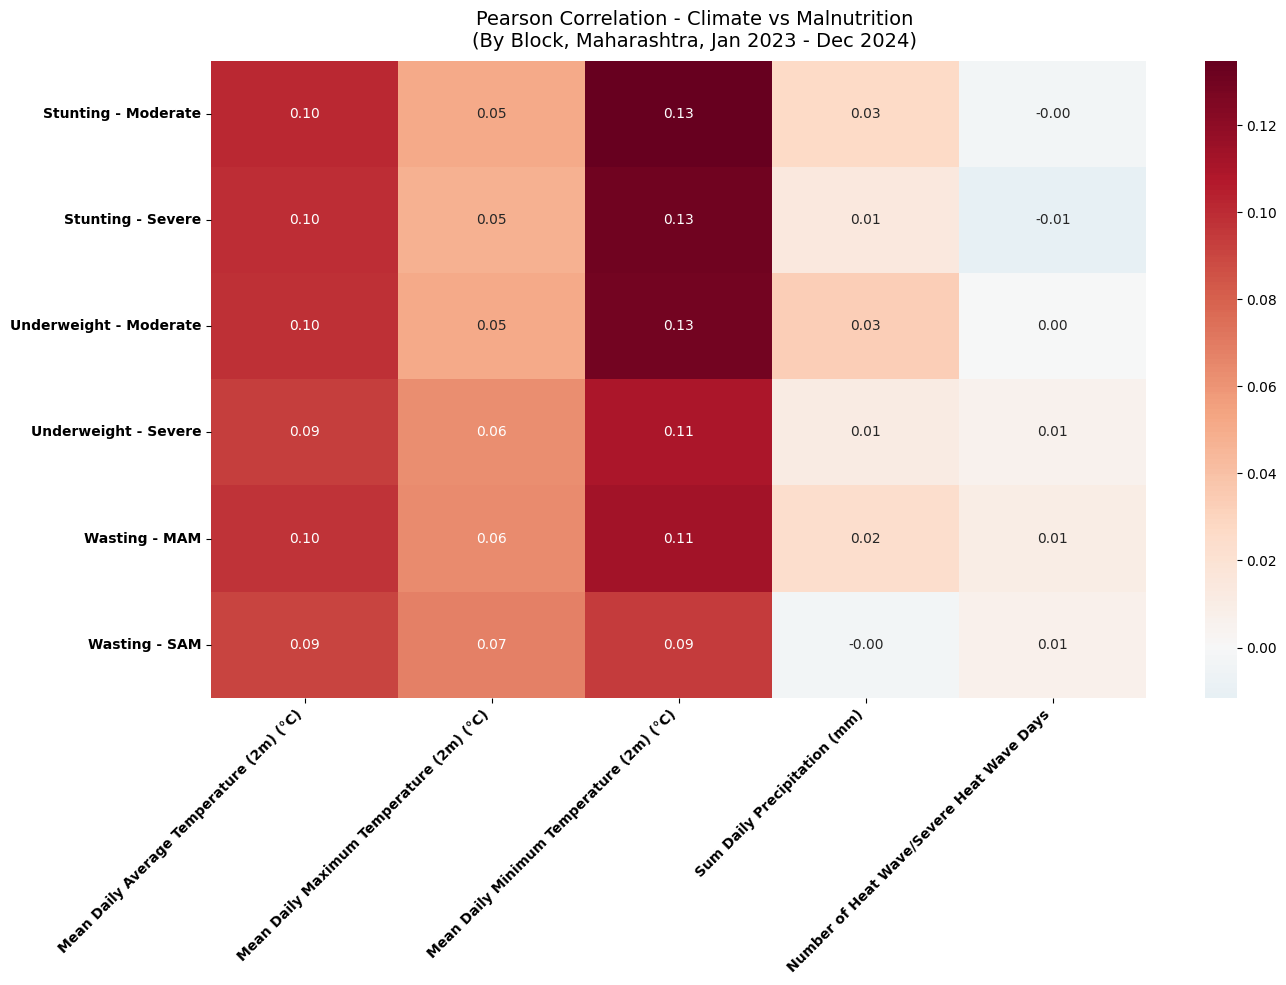


Top 3 correlated climate variables for each malnutrition indicator:

Stunting - Moderate:
  Mean Daily Minimum Temperature (2m) (°C): 0.135
  Mean Daily Average Temperature (2m) (°C): 0.101
  Mean Daily Maximum Temperature (2m) (°C): 0.051

Stunting - Severe:
  Mean Daily Minimum Temperature (2m) (°C): 0.131
  Mean Daily Average Temperature (2m) (°C): 0.099
  Mean Daily Maximum Temperature (2m) (°C): 0.048

Underweight - Moderate:
  Mean Daily Minimum Temperature (2m) (°C): 0.130
  Mean Daily Average Temperature (2m) (°C): 0.098
  Mean Daily Maximum Temperature (2m) (°C): 0.051

Underweight - Severe:
  Mean Daily Minimum Temperature (2m) (°C): 0.110
  Mean Daily Average Temperature (2m) (°C): 0.094
  Mean Daily Maximum Temperature (2m) (°C): 0.063

Wasting - MAM:
  Mean Daily Minimum Temperature (2m) (°C): 0.113
  Mean Daily Average Temperature (2m) (°C): 0.097
  Mean Daily Maximum Temperature (2m) (°C): 0.064

Wasting - SAM:
  Mean Daily Minimum Temperature (2m) (°C): 0.094
  Mean Da

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Compute correlation matrix
# --------------------------

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter relevant time range
df=raw.copy()

df.rename(columns={'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)': 'Sum Daily Precipitation (mm)'}, inplace=True)
# Define your variable groups
malnutrition_vars = [
    'Stunting - Moderate',
    'Stunting - Severe',
    'Underweight - Moderate',
    'Underweight - Severe',
    'Wasting - MAM',
    'Wasting - SAM'
]

heat_vars = [
'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (mm)',
      'Number of Heat Wave/Severe Heat Wave Days'
]


# Compute correlation matrix
corr_df = df[malnutrition_vars + heat_vars].corr(method='pearson')


# Extract submatrix: malnutrition (rows) x climate (columns)
corr_sub = corr_df.loc[malnutrition_vars, heat_vars]


# Plot the heatmap

# Plot the heatmap
plt.figure(figsize=(14, 10))

ax = sns.heatmap(
    corr_sub,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt=".2f"
)

# Rotate x-tick labels by 45 degrees and align them
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

plt.suptitle("Pearson Correlation - Climate vs Malnutrition\n(By Block, Maharashtra, Jan 2023 - Dec 2024)", fontsize=14)
plt.tight_layout()
plt.show()

# --------------------------
# Print Top Correlations
# --------------------------

print("\nTop 3 correlated climate variables for each malnutrition indicator:\n")

# Build a table to export


rows = []
for mal_var in malnutrition_vars:
    top_corr = corr_sub.loc[mal_var].abs().sort_values(ascending=False).head(3)
    actual_corrs = corr_sub.loc[mal_var][top_corr.index]
    print(f"{mal_var}:")
    for var, val in actual_corrs.items():
        print(f"  {var}: {val:.3f}")
        rows.append({
            'Malnutrition Indicator': mal_var,
            'Top Climate Variable': var,
            'Correlation Coefficient': round(val, 3)
        })
    print()

b. SE indicators

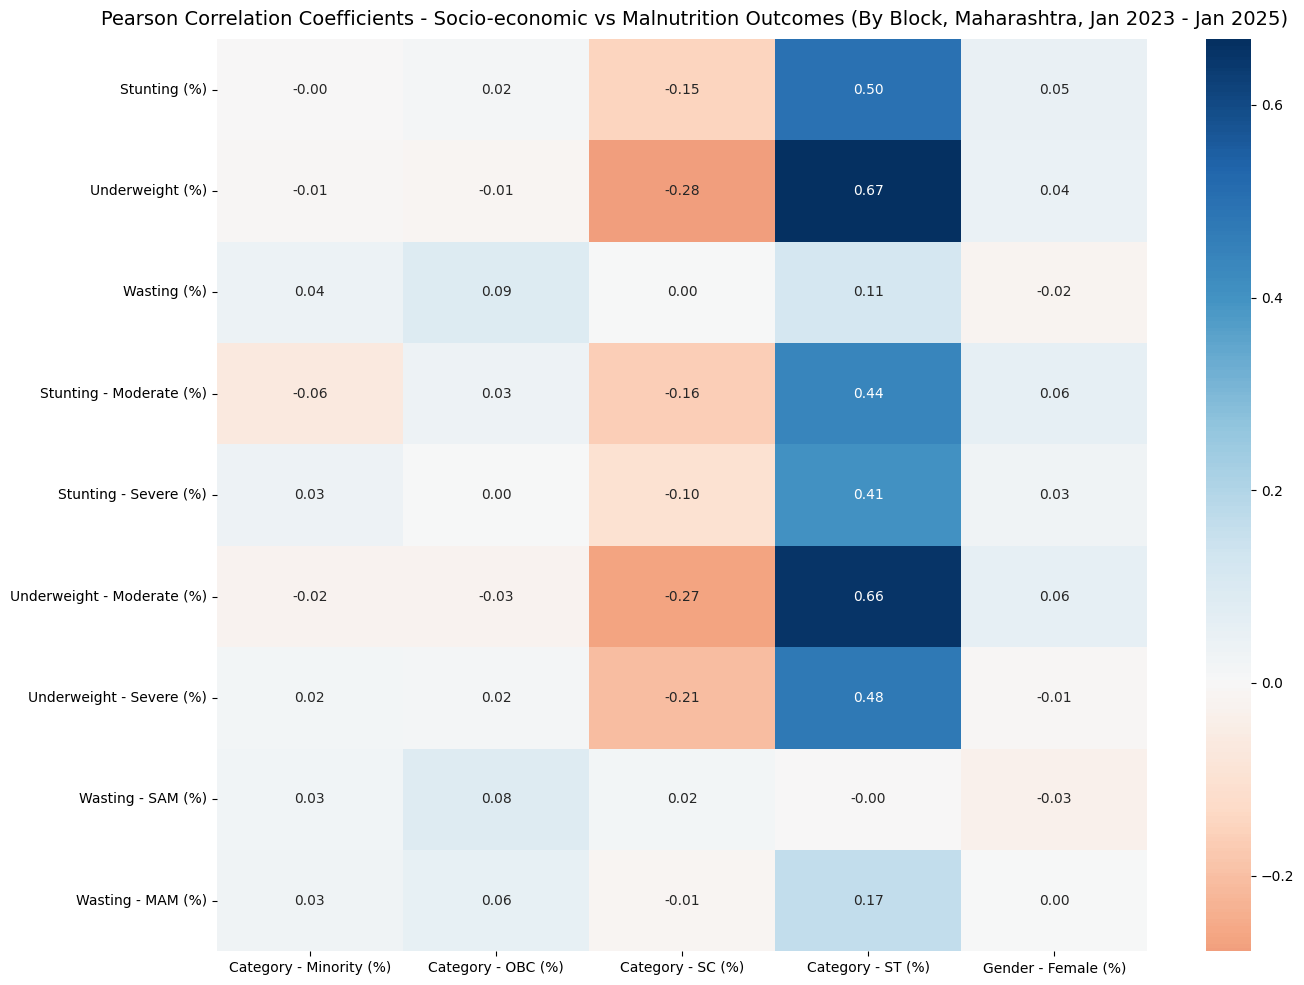


Top 3 correlated socio-economic variables for each malnutrition indicator:

Stunting (%):
  Category - ST (%): 0.498
  Category - SC (%): -0.148
  Gender - Female (%): 0.050

Underweight (%):
  Category - ST (%): 0.668
  Category - SC (%): -0.279
  Gender - Female (%): 0.043

Wasting (%):
  Category - ST (%): 0.114
  Category - OBC (%): 0.094
  Category - Minority (%): 0.041

Stunting - Moderate (%):
  Category - ST (%): 0.439
  Category - SC (%): -0.164
  Category - Minority (%): -0.060

Stunting - Severe (%):
  Category - ST (%): 0.405
  Category - SC (%): -0.102
  Category - Minority (%): 0.033

Underweight - Moderate (%):
  Category - ST (%): 0.656
  Category - SC (%): -0.270
  Gender - Female (%): 0.060

Underweight - Severe (%):
  Category - ST (%): 0.476
  Category - SC (%): -0.206
  Category - Minority (%): 0.021

Wasting - SAM (%):
  Category - OBC (%): 0.085
  Gender - Female (%): -0.031
  Category - Minority (%): 0.028

Wasting - MAM (%):
  Category - ST (%): 0.165
  Catego

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Compute correlation matrix
# --------------------------

corr_df = month_block_df[malnutrition_vars + socio_vars].corr(method='pearson')

# Extract submatrix: malnutrition (rows) x socio-economic (columns)
corr_sub = corr_df.loc[malnutrition_vars, socio_vars]

# --------------------------
# Plot heatmap
# --------------------------

plt.figure(figsize=(14, 10))
sns.heatmap(corr_sub, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.suptitle("Pearson Correlation Coefficients - Socio-economic vs Malnutrition Outcomes (By Block, Maharashtra, Jan 2023 - Jan 2025)", fontsize=14)
plt.tight_layout()
plt.savefig(f"{path}/bivariate/socio_economic_malnutrition_correlation.png", dpi=300)
plt.show()

# --------------------------
# Print Top Correlations
# --------------------------

print("\nTop 3 correlated socio-economic variables for each malnutrition indicator:\n")

# Build a table to export
rows = []
for mal_var in malnutrition_vars:
    top_corr = corr_sub.loc[mal_var].abs().sort_values(ascending=False).head(3)
    actual_corrs = corr_sub.loc[mal_var][top_corr.index]
    print(f"{mal_var}:")
    for var, val in actual_corrs.items():
        print(f"  {var}: {val:.3f}")
        rows.append({
            'Malnutrition Indicator': mal_var,
            'Top Socio-economic Variable': var,
            'Correlation Coefficient': round(val, 3)
        })
    print()


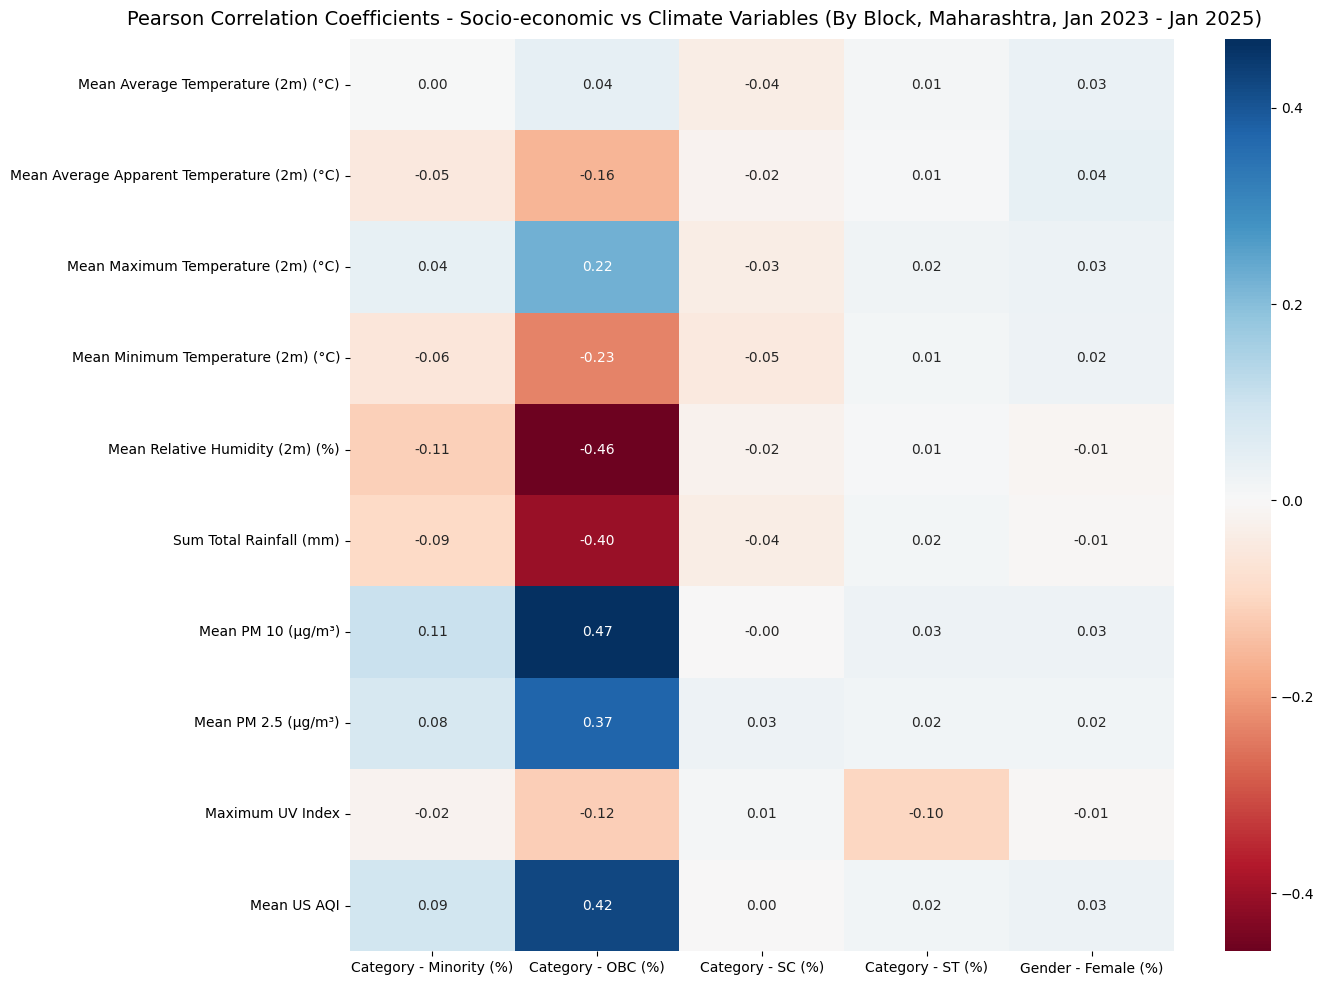


Top 3 correlated variables for each climate var

Mean Average Temperature (2m) (°C):
  Category - OBC (%): 0.043
  Category - SC (%): -0.035
  Gender - Female (%): 0.031

Mean Average Apparent Temperature (2m) (°C):
  Category - OBC (%): -0.158
  Category - Minority (%): -0.052
  Gender - Female (%): 0.038

Mean Maximum Temperature (2m) (°C):
  Category - OBC (%): 0.224
  Category - Minority (%): 0.040
  Category - SC (%): -0.035

Mean Minimum Temperature (2m) (°C):
  Category - OBC (%): -0.233
  Category - Minority (%): -0.059
  Category - SC (%): -0.048

Mean Relative Humidity (2m) (%):
  Category - OBC (%): -0.459
  Category - Minority (%): -0.114
  Category - SC (%): -0.020

Sum Total Rainfall (mm):
  Category - OBC (%): -0.402
  Category - Minority (%): -0.094
  Category - SC (%): -0.038

Mean PM 10 (μg/m³):
  Category - OBC (%): 0.470
  Category - Minority (%): 0.107
  Gender - Female (%): 0.027

Mean PM 2.5 (μg/m³):
  Category - OBC (%): 0.374
  Category - Minority (%): 0.079
 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Compute correlation matrix
# --------------------------

corr_df = month_block_df[ind_vars + socio_vars].corr(method='pearson')

# Extract submatrix: malnutrition (rows) x socio-economic (columns)
corr_sub = corr_df.loc[ind_vars, socio_vars]

# --------------------------
# Plot heatmap
# --------------------------

plt.figure(figsize=(14, 10))
sns.heatmap(corr_sub, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.suptitle("Pearson Correlation Coefficients - Socio-economic vs Climate Variables (By Block, Maharashtra, Jan 2023 - Jan 2025)", fontsize=14)
plt.tight_layout()
plt.savefig(f"{path}/bivariate/socio_economic_climate_correlation.png", dpi=300)
plt.show()

# --------------------------
# Print Top Correlations
# --------------------------

print("\nTop 3 correlated variables for each climate var\n")

# Build a table to export
rows = []
for var in ind_vars:
    top_corr = corr_sub.loc[var].abs().sort_values(ascending=False).head(3)
    actual_corrs = corr_sub.loc[var][top_corr.index]
    print(f"{var}:")
    for se_var, val in actual_corrs.items():
        print(f"  {se_var}: {val:.3f}")
        rows.append({
            'Climate Indicator': var,
            'Top Socio-economic Variable': se_var,
            'Correlation Coefficient': round(val, 3)
        })
    print()



# Time series:


In [ ]:
raw.columns

Index(['dtcode11', 'sdtcode11', 'month_year',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Sum Daily Rainfall Score (0-5)',
       'Number of Heavy & Extremely Rainfall Days', 'Number of Heat Wave Days',
       'Number of Severe Heat Wave Days', 'season', 'SPI', 'spi_category',
       'dtname', 'sdtname', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured',
       'Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - MAM (%)', 'Wasting - SAM (%)'],
      dtype='object')

In [ ]:
raw["month"]=pd.to_datetime(raw["month_year"])

In [ ]:
monthly_df=raw.groupby(by="month")[['Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured']].sum().reset_index()

In [ ]:
monthly_df.columns

Index(['month', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured'],
      dtype='object')

In [ ]:
change=monthly_df[monthly_df["month"].isin([monthly_df["month"].min(), monthly_df["month"].max()])]

In [ ]:
malnutrition_vars=['Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - MAM (%)', 'Wasting - SAM (%)']

In [ ]:
# Generate %
indicator_cols = [
    'Stunting - Moderate', 'Stunting - Severe',
    'Underweight - Moderate', 'Underweight - Severe',
    'Wasting - MAM', 'Wasting - SAM'
]

# Calculate percentages
for col in indicator_cols:
    pct_col = col + ' (%)'
    monthly_df[pct_col] = (monthly_df[col] / monthly_df['Number of Children Measured']) * 100


monthly_df[[col + ' (%)' for col in indicator_cols]] = monthly_df[[col + ' (%)' for col in indicator_cols]].round(2)



In [ ]:
change[["month"] + malnutrition_vars]

KeyError: "['Stunting - Moderate (%)', 'Stunting - Severe (%)', 'Underweight - Moderate (%)', 'Underweight - Severe (%)', 'Wasting - MAM (%)', 'Wasting - SAM (%)'] not in index"

In [ ]:
for i in range(len(malnutrition_vars)):
    print(change[malnutrition_vars[i]].diff())

KeyError: 'Stunting - Moderate (%)'

In [ ]:
change

,month,Stunting - Moderate,Stunting - Severe,Underweight - Moderate,Underweight - Severe,Wasting - MAM,Wasting - SAM,Number of Children Measured
0,2023-01-01,628591.0,591466.0,457317.0,127146.0,106946.0,40801.0,7484045.0
23,2024-12-01,1214208.0,1264637.0,799297.0,137008.0,154301.0,35850.0,15839126.0


In [ ]:
(628591.0/7484045.0)*100

8.399080978267769

1. Malnutrition

In [ ]:
import pandas as pd
import plotly.express as px
import panel as pn
pn.extension('plotly')

# Ensure 'Month' is datetime and sorted
monthly_df['month'] = pd.to_datetime(monthly_df['month'])
monthly_df = monthly_df.sort_values('month')

# Define indicator groups and variables
malnutrition_vars = [
    'Stunting - Moderate (%)', 'Stunting - Severe (%)',
    'Underweight - Moderate (%)', 'Underweight - Severe (%)',
    'Wasting - SAM (%)', 'Wasting - MAM (%)'
]

# Melt dataframe for plotting
melted = monthly_df.melt(id_vars='month', value_vars=malnutrition_vars,
                         var_name='Indicator', value_name='Value')

# Define color mapping
color_map = {
    'Stunting (%)': '#1f77b4',
    'Stunting - Moderate (%)': '#5fa2ce',
    'Stunting - Severe (%)': '#0d4a7e',
    'Underweight (%)': '#2ca02c',
    'Underweight - Moderate (%)': '#77c97c',
    'Underweight - Severe (%)': '#176d17',
    'Wasting (%)': '#d62728',
    'Wasting - SAM (%)': '#e98b8b',
    'Wasting - MAM (%)': '#8b1a1a',
}

# Create the plot
fig = px.line(
    melted,
    x='month',
    y='Value',
    color='Indicator',
    color_discrete_map=color_map,
    markers=True,
    title="Malnutrition Time-Series Trend, Maharashtra (Jan 2023 – Dec 2024)"
)

# Customize layout
fig.update_layout(
    height=600,
    width=1000,
    title={
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 22}
    },
    xaxis=dict(
        title='',
        tickmode='array',
        tickvals=melted['month'].sort_values().unique(),
        tickformat='%b%y',  # Optional: better formatting,
        tickangle=-45

    ),
    yaxis_title='% of Children Measured',
    legend_title_text='Indicator',
    margin=dict( b=90)
)


fig.add_annotation(
    text="*Data Source: Growth Monitoring line lists, POSHAN API",
    xref="paper", yref="paper",
    x=0, y=-0.2,  # Position it below the plot
    showarrow=False,
    font=dict(size=12, color="gray"),
    align="left"
)

# Optional: show or save
fig.show()
# fig.write_image(f"{path}/malnutrition_univariate/malnutrition_time_series.jpg")

fig.write_image("malnutrition_time_series.jpg")




<ipython-input-131-66af08c51e58>:4: UserWarning:

Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.



2. Temperature

In [ ]:
path

'drive/MyDrive/CHVI/Maharashtra/graphs'

In [ ]:
daily_temp=pd.read_csv("drive/MyDrive/CHVI/Maharashtra/data/raw/daily_vars_2020-01-01_to_2025-04-07.csv")

In [ ]:
daily_temp.columns

Index(['date', 'temperature_2m_mean', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'relative_humidity_2m_mean', 'Block',
       'District', 'Block_Code', 'District_Code', 'apparent_temperature_mean'],
      dtype='object')

In [ ]:
daily_temp=daily_temp[["date", 'temperature_2m_mean', 'temperature_2m_max',
       'temperature_2m_min']]

In [ ]:
daily_temp.rename(columns={
    'temperature_2m_mean': 'Mean Average Temperature (2m) (°C)',
    'temperature_2m_max': 'Mean Maximum Temperature (2m) (°C)',
    'temperature_2m_min': 'Mean Minimum Temperature (2m) (°C)'
}, inplace=True)

In [ ]:
daily_temp['date'] = pd.to_datetime(daily_temp['date']).dt.date

In [ ]:
daily_temp['date'] = pd.to_datetime(daily_temp['date'])

In [ ]:
import pandas as pd

# Create UTC-aware timestamps
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2024-12-31")

# Filter with timezone-aware Timestamps
daily_temp = daily_temp[
    (daily_temp["date"] >= start_date) &
    (daily_temp["date"] <= end_date)
]


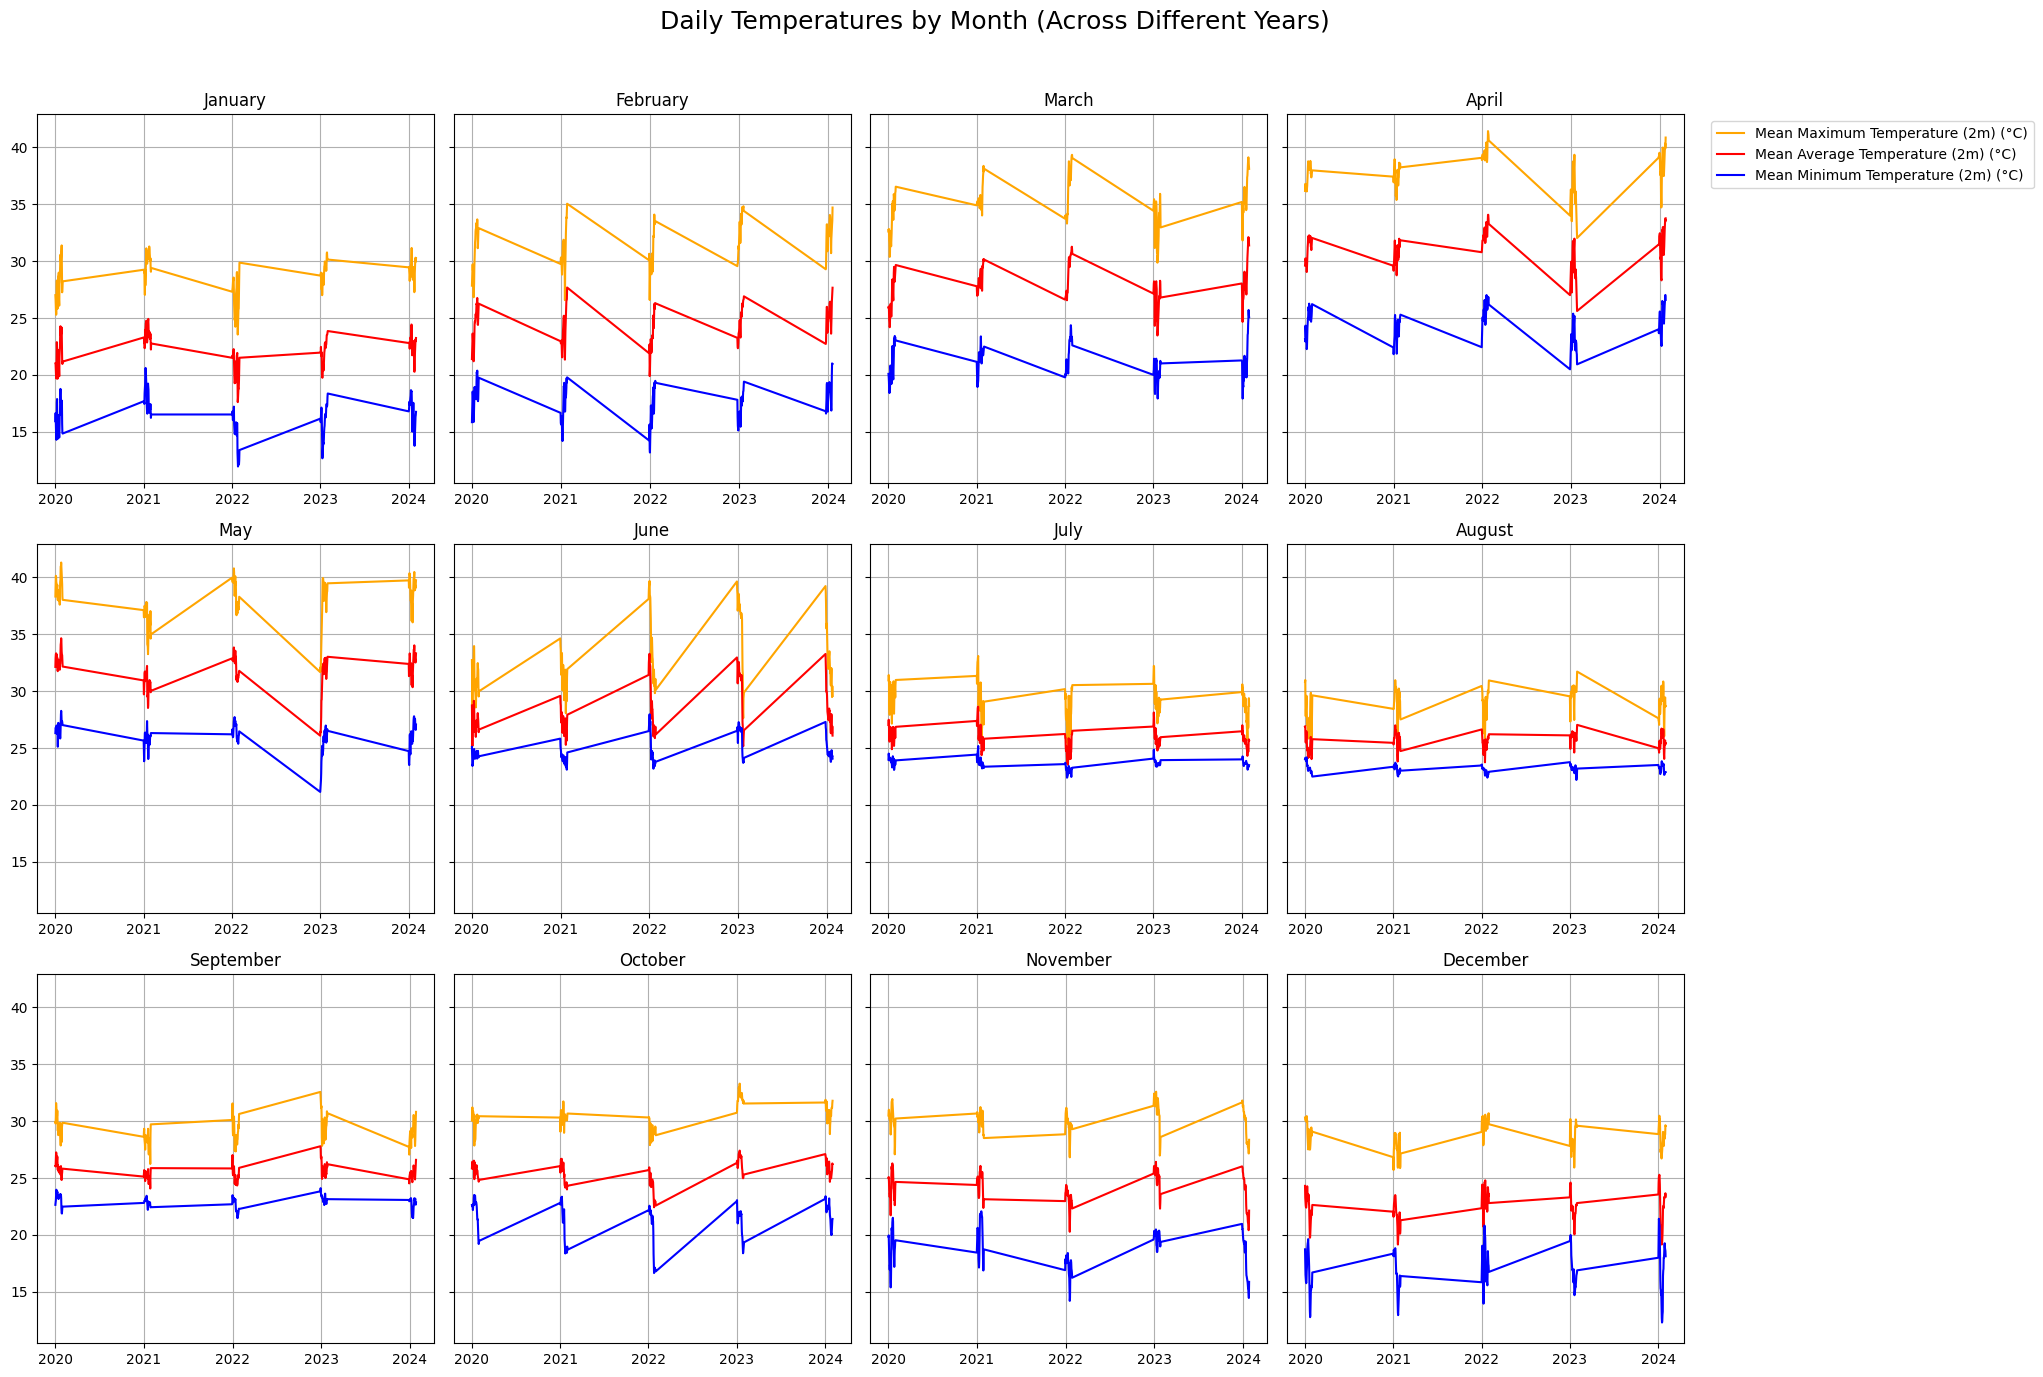

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Convert 'date' column to datetime
daily_temp['date'] = pd.to_datetime(daily_temp['date'])

# STEP 2: Average across blocks for each day (group by date)
daily_avg = daily_temp.groupby('date')[['Mean Maximum Temperature (2m) (°C)','Mean Average Temperature (2m) (°C)','Mean Minimum Temperature (2m) (°C)']].mean().reset_index()

# Define temperature columns
temp_cols = [

    'Mean Maximum Temperature (2m) (°C)',
        'Mean Average Temperature (2m) (°C)',
    'Mean Minimum Temperature (2m) (°C)'
]

# STEP 3: Add month and month name for plotting
daily_avg['month'] = daily_avg['date'].dt.month
daily_avg['month_name'] = daily_avg['date'].dt.month_name()

# STEP 4: Plotting
fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharey=True)
axes = axes.flatten()

colors = ['orange', 'red', 'blue']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Loop through each month
for idx, month in enumerate(range(1, 13)):
    ax = axes[idx]
    month_data = daily_avg[daily_avg['month'] == month]
    month_data = month_data.sort_values('date')
    # month_data['date']=month_data['date'].astype(str)

    # Plot only if there's data for that month
    if not month_data.empty:
        for col, color in zip(temp_cols, colors):
            ax.plot(month_data['date'], month_data[col], label=col, color=color)

        ax.set_title(month_order[month - 1])

        # Set x-ticks to show actual date and rotate labels for clarity
        ax.tick_params(axis='x', rotation=0)

        # # Format x-axis labels as year-month and show every 10th label to avoid overlap
        ax.set_xticks(month_data['date'].iloc[::31])  # Show every 10th date
        ax.set_xticklabels(month_data['date'].iloc[::31].dt.strftime('%Y'))

        ax.grid(True)

        # # Remove legend from all subplots except the first one
        # if idx != 0:
        #     ax.legend().set_visible(False)

# Add legend only once
axes[3].legend(loc='upper right', bbox_to_anchor=(1.9, 1))


fig.suptitle("Daily Temperatures by Month (Across Different Years)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlap
plt.savefig(f"{path}/climate_univariate/monthly_time_series.png", dpi=300)


In [ ]:
import pandas as pd
import plotly.express as px
import panel as pn
pn.extension('plotly')

# Convert 'Month' to datetime if needed
monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])

# Define indicator groups and variables
pol_vars = [
      'Mean PM 10 (μg/m³)',
       'Mean PM 2.5 (μg/m³)',
      'Mean US AQI'
]

# Melt dataframe for plotting
melted = monthly_df.melt(id_vars='Month', value_vars=pol_vars,
                         var_name='Indicator', value_name='Value')


# Create the plot
fig = px.line(
    melted,
    x='Month',
    y='Value',
    color='Indicator',
    # color_discrete_map=,
    markers=True,
    title="Pollution Time-Series Trend, Maharashtra (2023–2025)"
)

# Customize layout
fig.update_layout(
    height=600,
    width=1200,  # PPT-friendly wide format
    title={
        'x': 0.5,  # Center the title
        'xanchor': 'center',
        'font': {'size': 22}
    },
    legend_title_text='Indicator',
    margin=dict(l=40, r=40, t=60, b=40)
)

# Optional: show or save
fig.show()
fig.write_image(f"{path}/pollution_time_series.jpg")


In [ ]:
import pandas as pd
import plotly.express as px
import panel as pn
pn.extension('plotly')

# Convert 'Month' to datetime if needed
monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])

# Define indicator groups and variables
climate_vars = [
      'Mean PM 10 (μg/m³)',
       'Mean PM 2.5 (μg/m³)',
      'Mean US AQI'
]

# Melt dataframe for plotting
melted = monthly_df.melt(id_vars='Month', value_vars=pol_vars,
                         var_name='Indicator', value_name='Value')


# Create the plot
fig = px.line(
    melted,
    x='Month',
    y='Value',
    color='Indicator',
    # color_discrete_map=,
    markers=True,
    title="Pollution Time-Series Trend, Maharashtra (2023–2025)"
)

# Customize layout
fig.update_layout(
    height=600,
    width=1200,  # PPT-friendly wide format
    title={
        'x': 0.5,  # Center the title
        'xanchor': 'center',
        'font': {'size': 22}
    },
    legend_title_text='Indicator',
    margin=dict(l=40, r=40, t=60, b=40)
)

# Optional: show or save
fig.show()
fig.write_image(f"{path}/pollution_time_series.jpg")


Scaled - Time-series

In [ ]:
monthly_df["Month"]=pd.to_datetime(monthly_df["Month"])
monthly_df=monthly_df[monthly_df["Month"]<pd.to_datetime("2024-12-01")]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# ---- Variable groups ----
climate_vars = [
    'Mean Maximum Temperature (2m) (°C)',
    'Mean Average Temperature (2m) (°C)',
    'Mean Relative Humidity (2m) (%)',
    'Sum Total Rainfall (mm)'
]

malnutrition_vars = [
    'Underweight - Moderate (Count)',
    'Underweight - Severe (Count)',
    'Wasting - MAM (Count)',
    'Wasting - SAM (Count)'
]

# Full variable list for scaling
all_vars = climate_vars + malnutrition_vars

# Custom color map
custom_colors = {
    'Mean Maximum Temperature (2m) (°C)': '#D55E00',
    'Mean Average Temperature (2m) (°C)': '#0072B2',
    'Mean Relative Humidity (2m) (%)': '#56B4E9',
    'Sum Total Rainfall (mm)': '#CC79A7',
    'Underweight - Moderate (Count)': '#E69F00',
    'Underweight - Severe (Count)': '#999999',
    'Wasting - MAM (Count)': '#8C564B',
    'Wasting - SAM (Count)': '#F0E442'
}

# ---- Standardize ----
standardized_df = monthly_df[['Month'] + all_vars].copy()
scaler = StandardScaler()
standardized_df[all_vars] = scaler.fit_transform(standardized_df[all_vars])

# ---- Melt and combine ----
plots = []
for climate_var in climate_vars:
    plot_df = standardized_df[['Month', climate_var] + malnutrition_vars].copy()
    melted = plot_df.melt(id_vars='Month', var_name='Variable', value_name='Standardized Value')
    melted['Climate Variable'] = climate_var  # tag for faceting
    plots.append(melted)

combined_df = pd.concat(plots, ignore_index=True)

# ---- Plot ----
fig = px.line(
    combined_df,
    x='Month',
    y='Standardized Value',
    color='Variable',
    facet_col='Climate Variable',
    facet_col_wrap=2,
    color_discrete_map=custom_colors,
    title='Standardized Climate and Malnutrition Trends (2023–2024)',
    markers=True
)

# ---- Layout tweaks ----
fig.update_layout(
    height=900,
    width=1200,
    title={'x': 0.5, 'xanchor': 'center', 'font': {'size': 20}},
    legend_title_text='Variable',
    margin=dict(l=40, r=40, t=80, b=40)
)
fig.for_each_xaxis(lambda axis: axis.update(title='', tickangle=45))
fig.for_each_yaxis(lambda axis: axis.update(title='Standardized Value'))

# ---- Save ----
fig.write_html(f"{path}/climate_malnutrition_overlay.html")
fig.write_image(f"{path}/climate_malnutrition_overlay.jpg", scale=3)

fig.show()


# Block-wise correlation maps

In [ ]:
gdf=gpd.read_file('/content/drive/MyDrive/CHVI/Maharashtra/shapefiles/MH_Taluka_WCD/MH_Taluka_WCD.shp')

In [ ]:
gdf.drop_duplicates(inplace=True)

In [ ]:

gdf['sdtcode11'] = gdf['sdtcode11'].astype(str)

In [ ]:
gdf["sdtcode11"]=gdf["sdtcode11"].str[1:]

In [ ]:
raw_block["dtcode11"]=raw_block["dtcode11"].astype(str)
raw_block["sdtcode11"]=raw_block["sdtcode11"].astype(str)

In [ ]:
month_block_df=raw.copy()

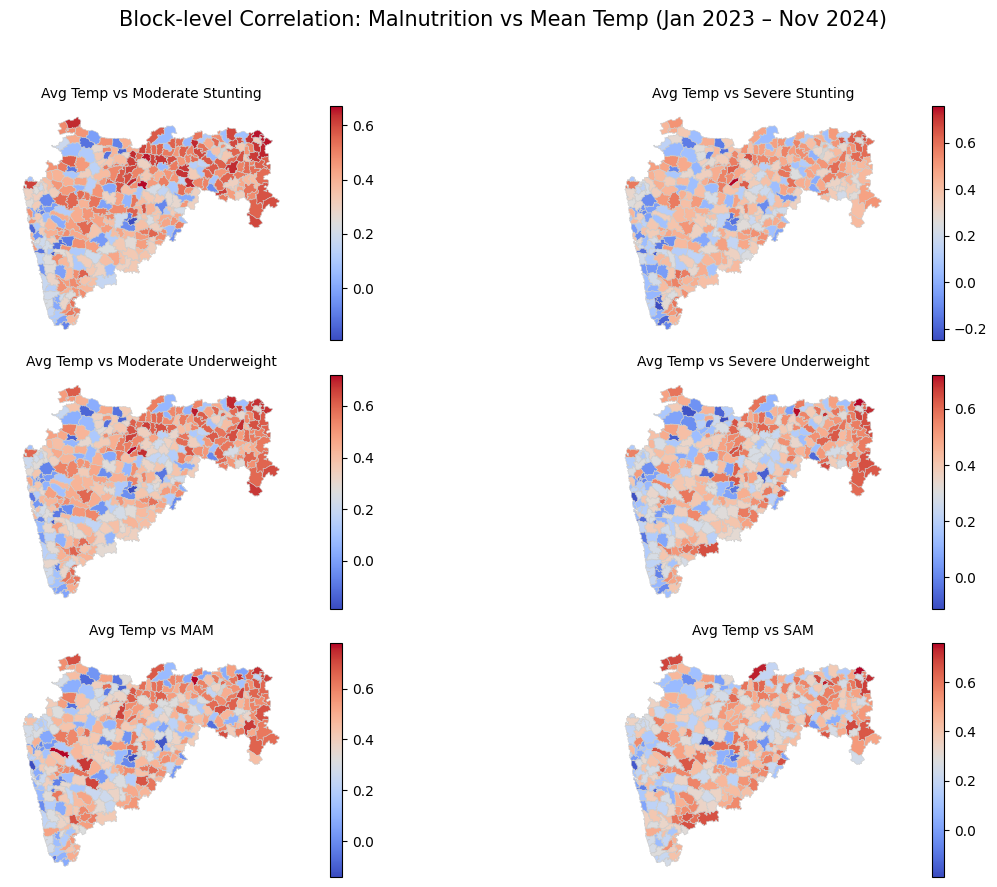


Blocks with high correlation (Moderate_Stunting_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, Moderate_Stunting_corr]
Index: []

Blocks with high correlation (Severe_Stunting_corr ≥ 0.7:
     dtname        sdtname sdtcode11  Severe_Stunting_corr
35  Buldana  Deolgaon Raja      3985              0.756804

Blocks with high correlation (Moderate_Underweight_corr ≥ 0.7:
     dtname        sdtname sdtcode11  Moderate_Underweight_corr
35  Buldana  Deolgaon Raja      3985                   0.720838

Blocks with high correlation (Severe_Underweight_corr ≥ 0.7:
     dtname  sdtname sdtcode11  Severe_Underweight_corr
95  Gondiya  Gondiya      4046                 0.722034
65   Wardha    Ashti      4015                 0.715165

Blocks with high correlation (MAM_Wasting_corr ≥ 0.7:
         dtname    sdtname sdtcode11  MAM_Wasting_corr
231        Pune   Ambegaon      4188          0.779158
65       Wardha      Ashti      4015          0.778436
95      Gondiya    Gondiya      

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Calculate Correlations ---
corrs = []
for block in month_block_df['sdtcode11'].unique():
    sub_df = month_block_df[month_block_df['sdtcode11'] == block]
    if len(sub_df) >= 6:
        corrs.append({
            'dtname': sub_df['dtname'].iloc[0],
            'sdtcode11': block,
            'sdtname': sub_df['sdtname'].iloc[0],
            'Moderate_Stunting_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Stunting - Moderate']),
            'Severe_Stunting_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Stunting - Severe']),
            'Moderate_Underweight_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Underweight - Moderate']),
            'Severe_Underweight_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Underweight - Severe']),
            'MAM_Wasting_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Wasting - MAM']),
            'SAM_Wasting_corr': sub_df['Mean Daily Average Temperature (2m) (°C)'].corr(sub_df['Wasting - SAM'])
        })

corr_df = pd.DataFrame(corrs)
# --- Step 2: Merge with GeoDataFrame ---
merged_gdf = gdf.merge(corr_df, on='sdtcode11', how='left')

# --- Step 3: Plotting Choropleths ---
fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows, 2 cols
axes = axes.flatten()

titles = [
    'Avg Temp vs Moderate Stunting',
    'Avg Temp vs Severe Stunting',
    'Avg Temp vs Moderate Underweight',
    'Avg Temp vs Severe Underweight',
    'Avg Temp vs MAM',
    'Avg Temp vs SAM'
]

cols = [
    'Moderate_Stunting_corr',
    'Severe_Stunting_corr',
    'Moderate_Underweight_corr',
    'Severe_Underweight_corr',
    'MAM_Wasting_corr',
    'SAM_Wasting_corr'
]

for i in range(6):
    merged_gdf.plot(
        column=cols[i],
        cmap='coolwarm',
        linewidth=0.4,
        edgecolor='0.8',
        legend=True,
        ax=axes[i],
        missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
    )
    axes[i].set_title(titles[i], fontsize=10)
    axes[i].axis('off')

plt.suptitle(
    "Block-level Correlation: Malnutrition vs Mean Temp (Jan 2023 – Nov 2024)",
    fontsize=15,
    x=0.6
)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.savefig(f"{path}/block_level_correlation_mean_temp.png", dpi=100, bbox_inches='tight')
plt.show()

# --- Step 4: Print High Correlation Blocks ---
threshold = 0.7
for col in cols:
    print(f"\nBlocks with high correlation ({col} ≥ {threshold}:")
    high_corr_blocks = corr_df[(corr_df[col]) >= threshold]
    print(high_corr_blocks[['dtname', 'sdtname', 'sdtcode11', col]].sort_values(by=col, ascending=False))


In [ ]:
month_block_df.columns

Index(['dtcode11', 'sdtcode11', 'month_year',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Sum Daily Rainfall Score (0-5)',
       'Number of Heavy & Extremely Rainfall Days', 'Number of Heat Wave Days',
       'Number of Severe Heat Wave Days', 'season', 'SPI', 'spi_category',
       'dtname', 'sdtname', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured',
       'Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - MAM (%)', 'Wasting - SAM (%)', 'month',
       'Number of Heat Wave/Severe Heat Wave Days', 'OBJECTID', 'stcode11',
       'Shape_Leng', 'Shape_Area', 'stname', 'Subdt_LGD', 'Dist_LGD',
       'Sta

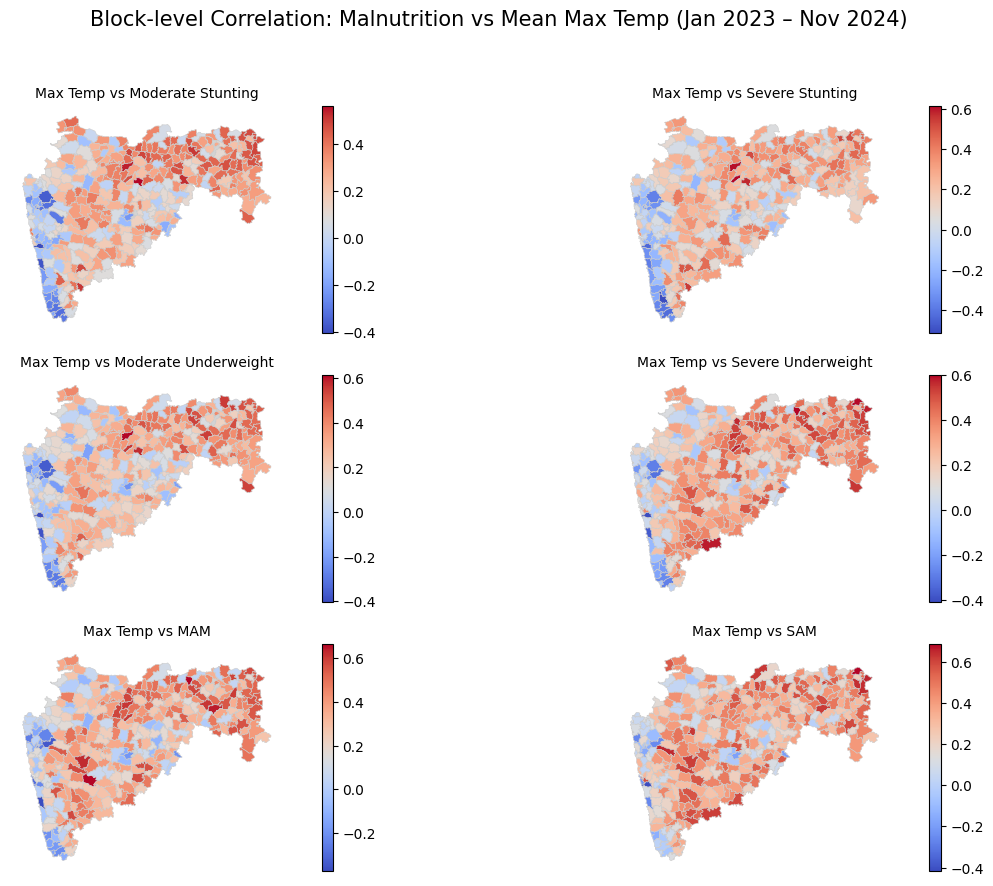


Blocks with high correlation (Moderate_Stunting_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, Moderate_Stunting_corr]
Index: []

Blocks with high correlation (Severe_Stunting_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, Severe_Stunting_corr]
Index: []

Blocks with high correlation (Moderate_Underweight_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, Moderate_Underweight_corr]
Index: []

Blocks with high correlation (Severe_Underweight_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, Severe_Underweight_corr]
Index: []

Blocks with high correlation (MAM_Wasting_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, MAM_Wasting_corr]
Index: []

Blocks with high correlation (SAM_Wasting_corr ≥ 0.7:
Empty DataFrame
Columns: [dtname, sdtname, sdtcode11, SAM_Wasting_corr]
Index: []


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Calculate Correlations ---
corrs = []
for block in month_block_df['sdtcode11'].unique():
    sub_df = month_block_df[month_block_df['sdtcode11'] == block]
    if len(sub_df) >= 6:
        corrs.append({
            'dtname': sub_df['dtname'].iloc[0],
            'sdtcode11': block,
            'sdtname': sub_df['sdtname'].iloc[0],
            'Moderate_Stunting_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Stunting - Moderate']),
            'Severe_Stunting_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Stunting - Severe']),
            'Moderate_Underweight_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Underweight - Moderate']),
            'Severe_Underweight_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Underweight - Severe']),
            'MAM_Wasting_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Wasting - MAM']),
            'SAM_Wasting_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df['Wasting - SAM'])
        })

corr_df = pd.DataFrame(corrs)

# --- Step 2: Merge with GeoDataFrame ---
merged_gdf = gdf.merge(corr_df, on='sdtcode11', how='left')

# --- Step 3: Plotting Choropleths ---
fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows, 2 cols
axes = axes.flatten()

titles = [
    'Max Temp vs Moderate Stunting',
    'Max Temp vs Severe Stunting',
    'Max Temp vs Moderate Underweight',
    'Max Temp vs Severe Underweight',
    'Max Temp vs MAM',
    'Max Temp vs SAM'
]

cols = [
    'Moderate_Stunting_corr',
    'Severe_Stunting_corr',
    'Moderate_Underweight_corr',
    'Severe_Underweight_corr',
    'MAM_Wasting_corr',
    'SAM_Wasting_corr'
]

for i in range(6):
    merged_gdf.plot(
        column=cols[i],
        cmap='coolwarm',
        linewidth=0.4,
        edgecolor='0.8',
        legend=True,
        ax=axes[i],
        missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
    )
    axes[i].set_title(titles[i], fontsize=10)
    axes[i].axis('off')

plt.suptitle(
    "Block-level Correlation: Malnutrition vs Mean Max Temp (Jan 2023 – Nov 2024)",
    fontsize=15,
    x=0.6
)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.savefig(f"{path}/block_level_correlation_max_temp.png", dpi=100, bbox_inches='tight')
plt.show()

# --- Step 4: Print High Correlation Blocks ---
threshold = 0.7
for col in cols:
    print(f"\nBlocks with high correlation ({col} ≥ {threshold}:")
    high_corr_blocks = corr_df[corr_df[col] >= threshold]
    print(high_corr_blocks[['dtname','sdtname', 'sdtcode11', col]].sort_values(by=col, ascending=False))


In [ ]:
month_block_df.columns

Index(['dtcode11', 'sdtcode11', 'month_year',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Sum Daily Rainfall Score (0-5)',
       'Number of Heavy & Extremely Rainfall Days', 'Number of Heat Wave Days',
       'Number of Severe Heat Wave Days', 'season', 'SPI', 'spi_category',
       'dtname', 'sdtname', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured',
       'Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - MAM (%)', 'Wasting - SAM (%)', 'month',
       'Number of Heat Wave/Severe Heat Wave Days', 'OBJECTID', 'stcode11',
       'Shape_Leng', 'Shape_Area', 'stname', 'Subdt_LGD', 'Dist_LGD',
       'Sta

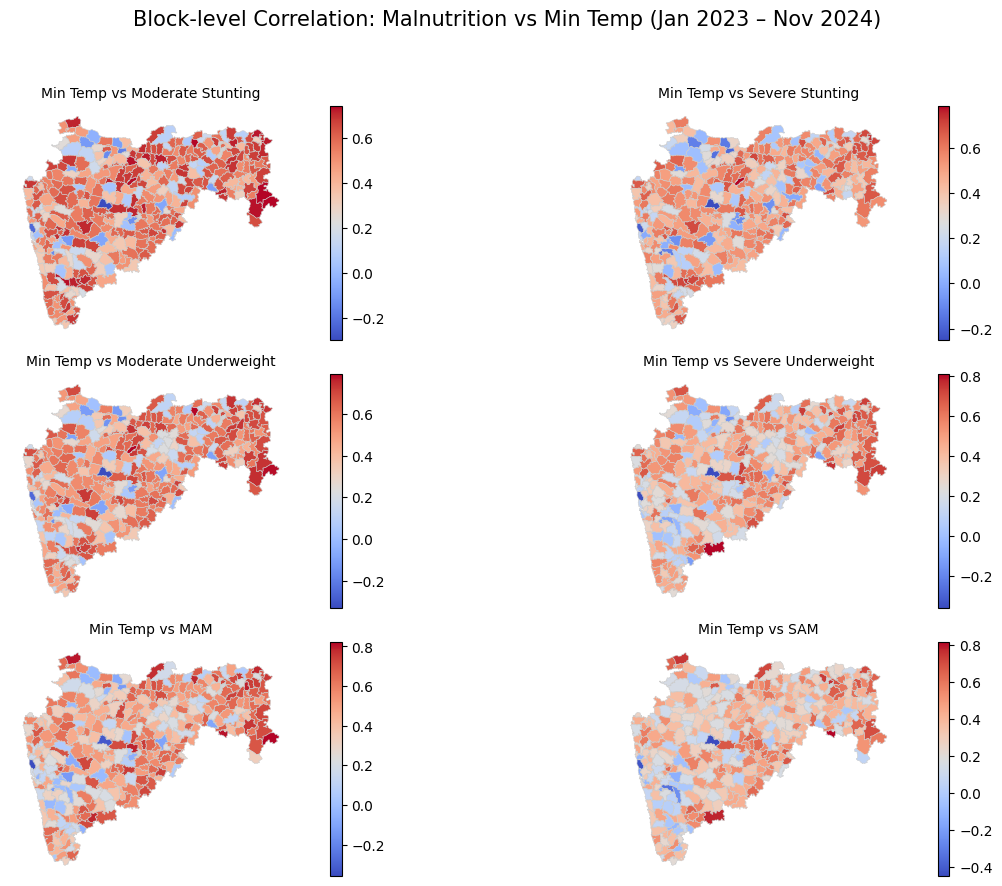


Blocks with high correlation (Moderate_Stunting_corr ≥ 0.7:
         dtname          sdtname sdtcode11  Moderate_Stunting_corr
110  Gadchiroli        Bhamragad      4061                0.745761
109  Gadchiroli         Etapalli      4060                0.744959
65       Wardha            Ashti      4015                0.743008
35      Buldana    Deolgaon Raja      3985                0.736212
336      Sangli          Shirala      4295                0.736011
30      Buldana           Motala      3980                0.732361
111  Gadchiroli            Aheri      4062                0.730179
95      Gondiya          Gondiya      4046                0.726489
97      Gondiya         Salekasa      4048                0.723052
27      Buldana          Shegaon      3977                0.722880
79       Nagpur            Mauda      4029                0.720885
41        Akola            Akola      3991                0.718307
168    Parbhani          Manwath      4119                0.717486
3

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Calculate Correlations ---
corrs = []
for block in month_block_df['sdtcode11'].unique():
    sub_df = month_block_df[month_block_df['sdtcode11'] == block]
    if len(sub_df) >= 6:
        corrs.append({
            'dtname': sub_df['dtname'].iloc[0],
            'sdtcode11': block,
            'sdtname': sub_df['sdtname'].iloc[0],
            'Moderate_Stunting_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Stunting - Moderate']),
            'Severe_Stunting_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Stunting - Severe']),
            'Moderate_Underweight_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Underweight - Moderate']),
            'Severe_Underweight_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Underweight - Severe']),
            'MAM_Wasting_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Wasting - MAM']),
            'SAM_Wasting_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df['Wasting - SAM'])
        })

corr_df = pd.DataFrame(corrs)

# --- Step 2: Merge with GeoDataFrame ---
merged_gdf = gdf.merge(corr_df, on='sdtcode11', how='left')

# --- Step 3: Plotting Choropleths ---
fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows, 2 cols
axes = axes.flatten()

titles = [
    'Min Temp vs Moderate Stunting',
    'Min Temp vs Severe Stunting',
    'Min Temp vs Moderate Underweight',
    'Min Temp vs Severe Underweight',
    'Min Temp vs MAM',
    'Min Temp vs SAM'
]

cols = [
    'Moderate_Stunting_corr',
    'Severe_Stunting_corr',
    'Moderate_Underweight_corr',
    'Severe_Underweight_corr',
    'MAM_Wasting_corr',
    'SAM_Wasting_corr'
]

for i in range(6):
    merged_gdf.plot(
        column=cols[i],
        cmap='coolwarm',
        linewidth=0.4,
        edgecolor='0.8',
        legend=True,
        ax=axes[i],
        missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
    )
    axes[i].set_title(titles[i], fontsize=10)
    axes[i].axis('off')

plt.suptitle(
    "Block-level Correlation: Malnutrition vs Min Temp (Jan 2023 – Nov 2024)",
    fontsize=15,
    x=0.6
)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.savefig(f"{path}/block_level_correlation_min_temp.png", dpi=100, bbox_inches='tight')
plt.show()

# --- Step 4: Print High Correlation Blocks ---
threshold = 0.7
for col in cols:
    print(f"\nBlocks with high correlation ({col} ≥ {threshold}:")
    high_corr_blocks = corr_df[(corr_df[col]) >= threshold]
    print(high_corr_blocks[['dtname', 'sdtname', 'sdtcode11', col]].sort_values(by=col, ascending=False))


# Malnutrition trends - choropleths



In [ ]:
raw["sdtcode11"]=raw["sdtcode11"].astype(str)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os

# Optional: Save to a directory
# path = "drive/MyDrive/CHVI/Maharashtra/graphs/malnutrition_trends"
# os.makedirs(path, exist_ok=True)

# Load your raw malnutrition data (raw) and block shapefile (gdf)
# Ensure `gdf` has 'sdtcode11' and 'geometry'
# Ensure `raw` has 'Month' (datetime), 'sdtcode11', and indicator columns

# Ensure Month column is datetime
raw['month'] = pd.to_datetime(raw['month'])

# Define indicator variables
key_vars = [
    "Underweight - Moderate (%)",
    "Underweight - Severe (%)",
    "Wasting - SAM (%)",
    "Wasting - MAM (%)",
    "Stunting - Moderate (%)",
    "Stunting - Severe (%)"
]

# Get all months in the dataset
months = sorted(raw['month'].dt.to_period('M').unique().to_timestamp())

# Create a full grid of all blocks and months
all_blocks = gdf[['sdtcode11', 'geometry']].drop_duplicates()
all_months = pd.DataFrame({'month': months})
full_index = all_months.assign(key=1).merge(all_blocks.assign(key=1), on='key').drop(columns='key')

# Merge raw data into the full grid
choropleth_df = pd.merge(full_index, raw, on=['sdtcode11', 'month'], how='left')

# Fill missing indicator values with 0
choropleth_df[key_vars] = choropleth_df[key_vars].fillna(0)

# Create a GeoDataFrame
choropleth_gdf = gpd.GeoDataFrame(choropleth_df, geometry='geometry', crs=gdf.crs)

# Loop over each variable to plot monthly choropleths
for var in key_vars:
    vmin = choropleth_gdf[var].min()
    vmax = choropleth_gdf[var].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = 'Oranges'  # Customize this per variable if desired

    for month in months:
        df_month = choropleth_gdf[choropleth_gdf['month'].dt.to_period('M') == month.to_period('M')]

        fig, ax = plt.subplots(figsize=(12, 12))
        df_month.plot(
            column=var,
            cmap=cmap,
            linewidth=0.3,
            ax=ax,
            edgecolor='0.5',
            norm=norm,
            legend=True,
            missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
        )
        ax.set_title(f"{var} - {month.strftime('%b %Y')}", fontsize=16)
        ax.axis('off')

        filename = f"{var.replace('%','').replace(' ','_')}_{month.strftime('%Y_%m')}.png"
        # filename = os.path.join(path, filename)  # Uncomment if saving to a path
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()


In [ ]:
from PIL import Image
import glob
import os

# Directory where PNGs are saved
# input_dir = "drive/MyDrive/CHVI/Maharashtra/graphs/malnutrition_trends"
# output_dir = f"{path}"
# os.makedirs(output_dir, exist_ok=True)

# Define your variables again if not already
key_vars = ["Underweight - Moderate (%)",
"Underweight - Severe (%)",
            "Wasting - SAM (%)",
"Wasting - MAM (%)",
          "Stunting - Moderate (%)",
"Stunting - Severe (%)"]

for var in key_vars:
    sanitized_var = var.replace('%', '').replace(' ', '_')
    # frame_paths = sorted(glob.glob(f"{input_dir}/{sanitized_var}_*.png"))
    frame_paths = sorted(glob.glob(f"{sanitized_var}_*.png"))

    if not frame_paths:
        print(f"No frames found for {var}")
        continue

    # Load frames safely
    frames = []
    for fpath in frame_paths:
        try:
            img = Image.open(fpath).convert("RGB")  # Ensure compatibility
            frames.append(img)
        except Exception as e:
            print(f"Failed to load {fpath}: {e}")

    if not frames:
        print(f"No valid images to create GIF for {var}")
        continue

    # Save to GIF
    # gif_path = os.path.join(output_dir, f"{sanitized_var}.gif")
    frames[0].save(
        # f"{path}/{sanitized_var}.gif",
        f"{sanitized_var}.gif",
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=500,  # ms per frame
        loop=1
    )


In [ ]:
# STL

In [ ]:
# Ensure datetime format
monthly_df['month'] = pd.to_datetime(monthly_df['month'])
monthly_df = monthly_df.set_index('month')


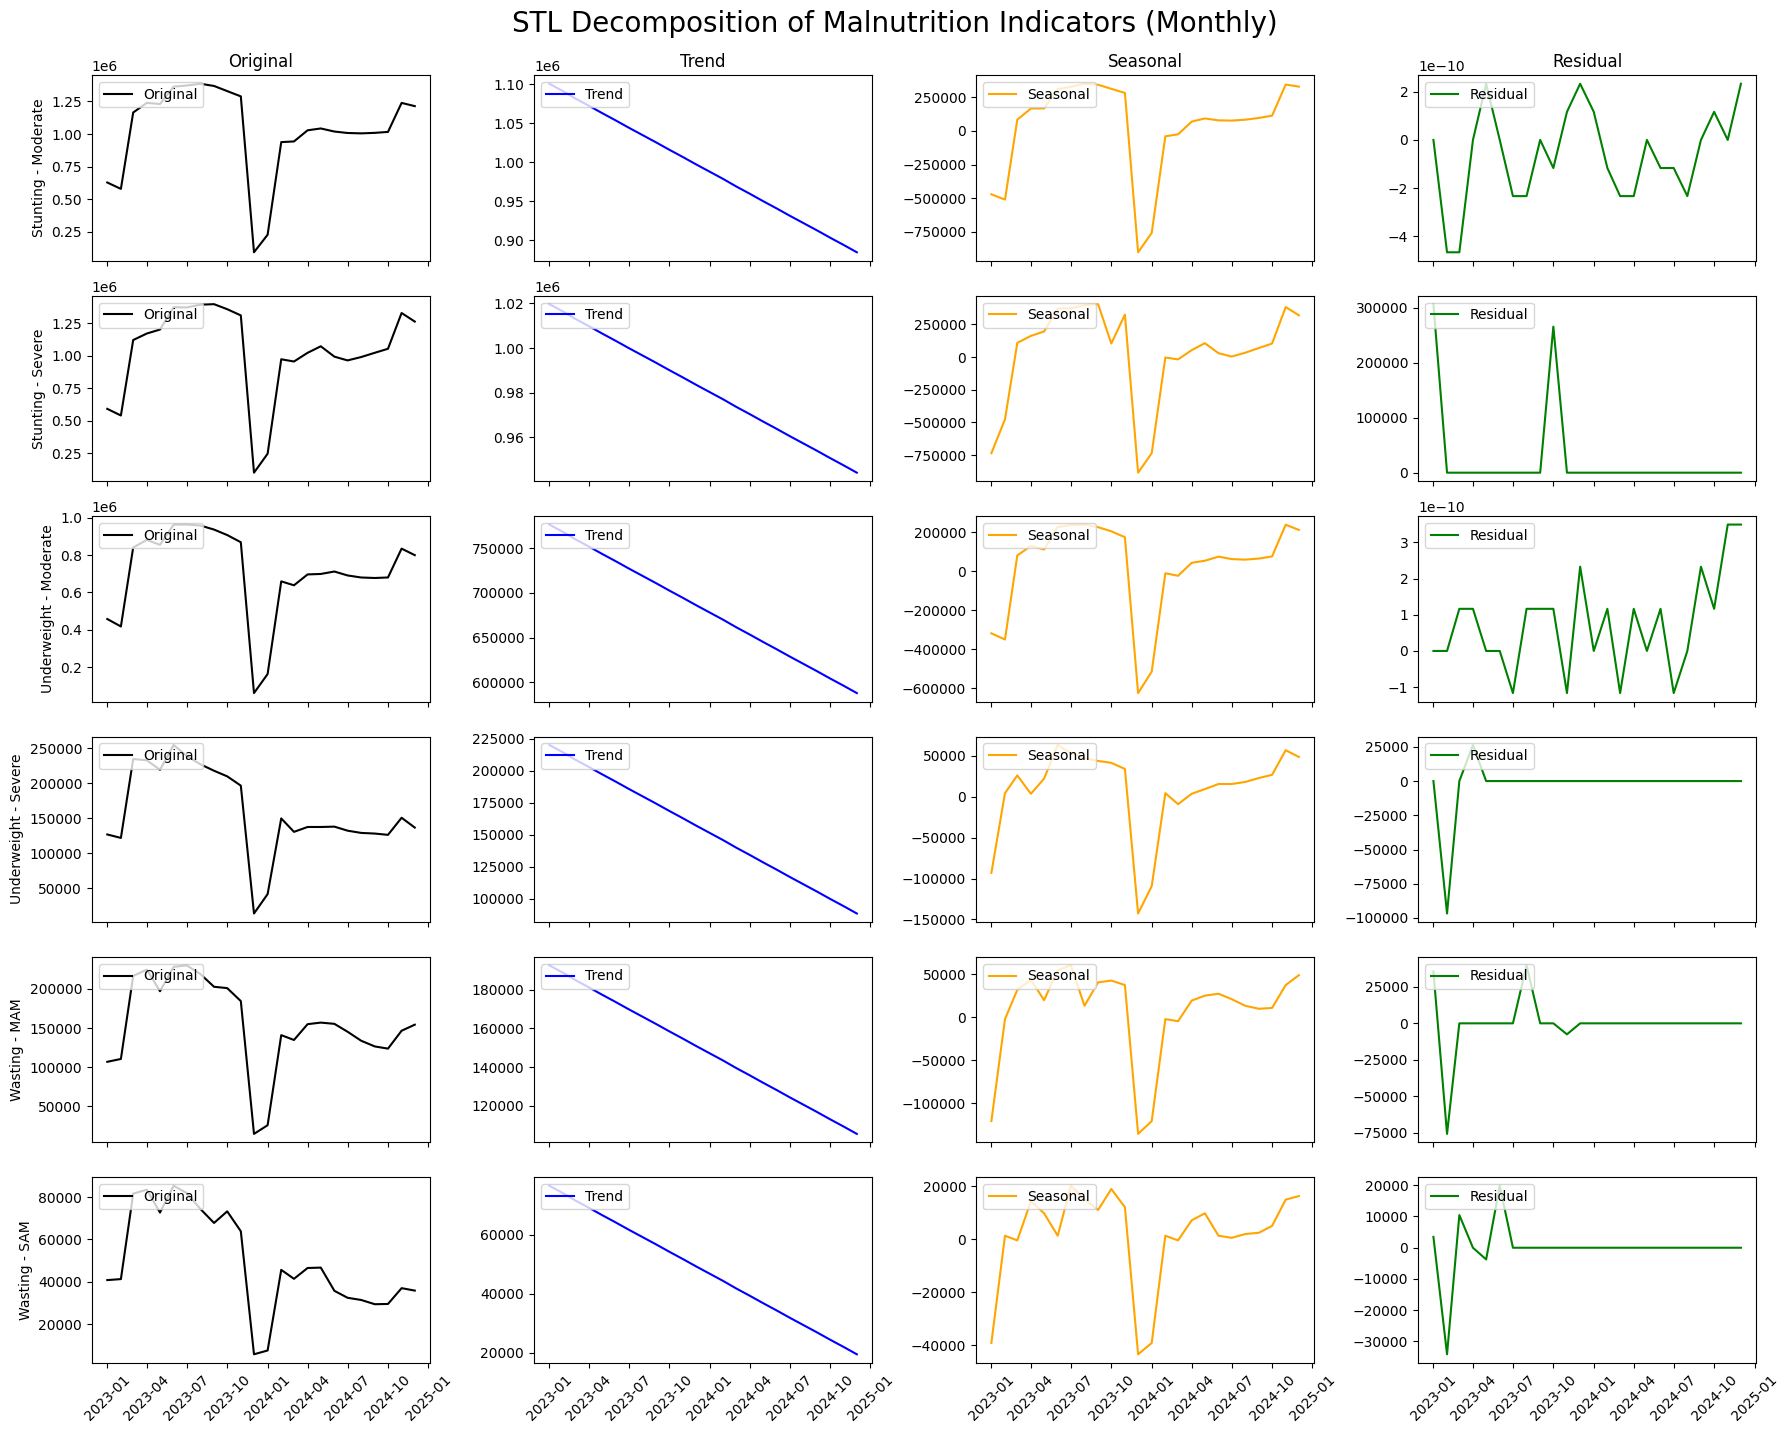

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# List of indicators
indicators = [
    'Stunting - Moderate', 'Stunting - Severe',
    'Underweight - Moderate', 'Underweight - Severe',
    'Wasting - MAM', 'Wasting - SAM'
]

# Set up 6 rows (indicators) × 4 cols (original, trend, seasonal, residual)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(18,14), sharex='col')

# Plot for each indicator
for i, indicator in enumerate(indicators):
    series = monthly_df[indicator].dropna()
    stl = STL(series, period=12, robust=True)
    result = stl.fit()

    # Original series
    axes[i, 0].plot(series, label='Original', color='black')
    axes[i, 0].set_ylabel(indicator, fontsize=10)
    axes[i, 0].legend(loc='upper left')

    # Trend
    axes[i, 1].plot(result.trend, label='Trend', color='blue')
    axes[i, 1].legend(loc='upper left')

    # Seasonal
    axes[i, 2].plot(result.seasonal, label='Seasonal', color='orange')
    axes[i, 2].legend(loc='upper left')

    # Residual
    axes[i, 3].plot(result.resid, label='Residual', color='green')
    axes[i, 3].legend(loc='upper left')

    # Rotate x-axis ticks for all columns in the current row
    for j in range(4):
        axes[i, j].tick_params(axis='x', rotation=45)

# Set column titles
column_titles = ['Original', 'Trend', 'Seasonal', 'Residual']
for ax, title in zip(axes[0], column_titles):
    ax.set_title(title, fontsize=12)

plt.tight_layout()
plt.suptitle('STL Decomposition of Malnutrition Indicators (Monthly)', fontsize=20, y=1.02)
plt.show()


# Processes

In [ ]:
ece=pd.read_csv("ece_att.csv")
services_block=pd.read_csv("drive/MyDrive/CHVI/Maharashtra/data/services_block.csv")
services_month_blocks=pd.read_csv("drive/MyDrive/CHVI/Maharashtra/data/services_month_block.csv")

In [ ]:
ece["year"]=ece["year"].astype(str)
ece["month"]=ece["month"].astype(str)

In [ ]:
ece["month_year"]=pd.to_datetime(ece["year"]+"-"+ece["month"]).dt.to_period("M")

In [ ]:
services_month_blocks["month_year"]=pd.to_datetime(services_month_blocks["month_year"]).dt.to_period("M")

In [ ]:
services_month_blocks=ece.merge(services_month_blocks, on=["sdtcode11", "month_year"],how="outer").drop(columns=['month_x', 'year_x','year_y',
       'month_y'])

In [ ]:
ece.columns

Index(['month', 'year', 'ece_att', 'sdtcode11', 'month_year'], dtype='object')

In [ ]:
ece_block=ece.drop(columns=["month", "year", "month_year"]).groupby(by="sdtcode11").sum().reset_index()

KeyError: "['month_year'] not found in axis"

In [ ]:
services_block=ece_block.merge(services_block, how="outer")

In [ ]:
import numpy as np
services_month=services_month_blocks.groupby(by="month_year").agg(
    {'ece_att': 'sum',
     'home_visits':'sum',
     'cbe_event_count': 'sum',
     'thr':'sum'}, observed=False).reset_index().replace(0, np.nan)

In [ ]:
import pandas as pd
import plotly.express as px
import panel as pn
pn.extension('plotly')

# Ensure 'Month' is datetime and sorted

# Convert Period[M] to datetime (start of month)
services_month["month"] = services_month['month_year'].dt.to_timestamp()

# Sort by the new datetime column
services_month = services_month.sort_values('month')

# Define indicator groups and variables
vars = [
    'ece_att', 'home_visits', 'cbe_event_count', 'thr'
]

# Melt dataframe for plotting
melted = services_month.melt(id_vars='month', value_vars=vars,
                         var_name='Indicator', value_name='Value')

# Define color mapping
color_map = {
    'ece_att': '#1f77b4',
    'home_visits': '#5fa2ce',
    'cbe_event_count': '#0d4a7e',
    'thr': '#2ca02c',
}

# Create the plot
fig = px.line(
    melted,
    x='month',
    y='Value',
    color='Indicator',
    color_discrete_map=color_map,
    markers=True,
    title="ICDS Services Time-Series Trend, Maharashtra (2024)"
)

# Customize layout
fig.update_layout(
    height=600,
    width=1000,
    title={
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 22}
    },
    xaxis=dict(
        title='',
        tickmode='array',
        tickvals=melted['month'].sort_values().unique(),
        tickformat='%b%y',  # Optional: better formatting,
        tickangle=-45

    ),
    yaxis_title='Number of Beneficiaries/events',
    legend_title_text='Indicator',
    margin=dict( b=90)
)


fig.add_annotation(
    text="*Data Source: POSHAN API",
    xref="paper", yref="paper",
    x=0, y=-0.2,  # Position it below the plot
    showarrow=False,
    font=dict(size=12, color="gray"),
    align="left"
)

# Optional: show or save
fig.show()
# fig.write_image(f"{path}/malnutrition_univariate/malnutrition_time_series.jpg")

fig.write_image("icds_time_series.jpg")




<ipython-input-132-7d835cab8bbe>:4: UserWarning:

Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.



In [ ]:
# services_month_blocks['Number of Heat Wave/Severe Heat Wave Days']=services_month_blocks['Number of Heat Wave Days'] + services_month_blocks['Number of Severe Heat Wave Days']

In [ ]:
services_month_blocks["sdtcode11"]=services_month_blocks["sdtcode11"].astype(str)

In [ ]:
services_month_blocks=services_month_blocks.merge(gdf, on="sdtcode11", how="right")

In [ ]:
services_block["sdtcode11"]=services_block["sdtcode11"].astype(str)

In [ ]:
services_block=services_block.merge(gdf, on="sdtcode11", how="right")

In [ ]:
services_month_blocks.columns


Index(['sdtcode11', 'year', 'month', 'thr_adolescent_girls',
       'thr_children_3y_6y', 'thr_children_6m_3y', 'thr_lactating_mothers',
       'thr_pregnant_woman', 'thr', 'home_visits_0m-6m', 'home_visits_6m_3y',
       'home_visits_lactating_mothers', 'home_visits_pregnant_women',
       'home_visits', 'cbe_event_count', 'month_year', 'dtcode11_x',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Sum Daily Rainfall Score (0-5)',
       'Number of Heavy & Extremely Rainfall Days', 'Number of Heat Wave Days',
       'Number of Severe Heat Wave Days', 'season', 'SPI', 'spi_category',
       'dtname_x', 'sdtname_x', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured',
       'Stunting - Moderate

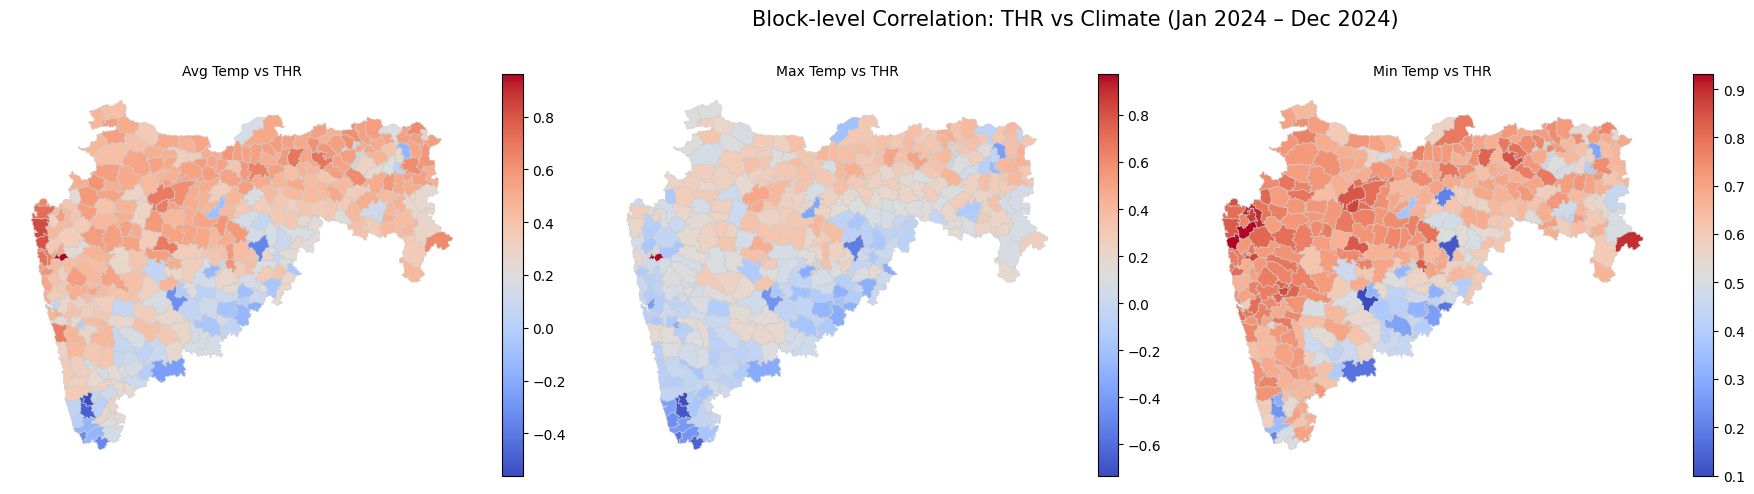

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Calculate Correlations ---
corrs = []
for block in services_month_blocks['sdtcode11'].unique():
    sub_df = services_month_blocks[services_month_blocks['sdtcode11'] == block]
    if len(sub_df) >= 6:
        corrs.append({
            'sdtcode11': block,
            'Avg_daily_temp_corr': sub_df[ 'Mean Daily Average Temperature (2m) (°C)'].corr(sub_df["thr"]),
            'Avg_max_temp_corr': sub_df['Mean Daily Maximum Temperature (2m) (°C)'].corr(sub_df["thr"]),
            'Avg_min_temp_corr': sub_df['Mean Daily Minimum Temperature (2m) (°C)'].corr(sub_df["thr"])
        })

corr_df = pd.DataFrame(corrs)

# --- Step 2: Merge with GeoDataFrame ---
merged_gdf = gdf.merge(corr_df, on='sdtcode11', how='left')

# --- Step 3: Plotting Choropleths ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

titles = [
    'Avg Temp vs THR',
    'Max Temp vs THR',
    'Min Temp vs THR',
]

cols = [
    'Avg_daily_temp_corr',
    'Avg_max_temp_corr',
    'Avg_min_temp_corr',
]

for i in range(3):
    merged_gdf.plot(
        column=cols[i],
        cmap='coolwarm',
        linewidth=0.4,
        edgecolor='0.8',
        legend=True,
        ax=axes[i],
        missing_kwds={'color': 'lightgrey', 'label': 'Missing data'}
    )
    axes[i].set_title(titles[i], fontsize=10)
    axes[i].axis('off')

plt.suptitle(
    "Block-level Correlation: THR vs Climate (Jan 2024 – Dec 2024)",
    fontsize=15,
    x=0.6
)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.savefig(f"{path}/block_level_correlation_min_temp.png", dpi=100, bbox_inches='tight')
plt.show()

# # --- Step 4: Print High Correlation Blocks ---
# threshold = 0.7
# for col in cols:
#     print(f"\nBlocks with high correlation ({col} ≥ {threshold}:")
#     high_corr_blocks = corr_df[(corr_df[col]) >= threshold]
#     print(high_corr_blocks[['dtname', 'sdtname', 'sdtcode11', col]].sort_values(by=col, ascending=False))


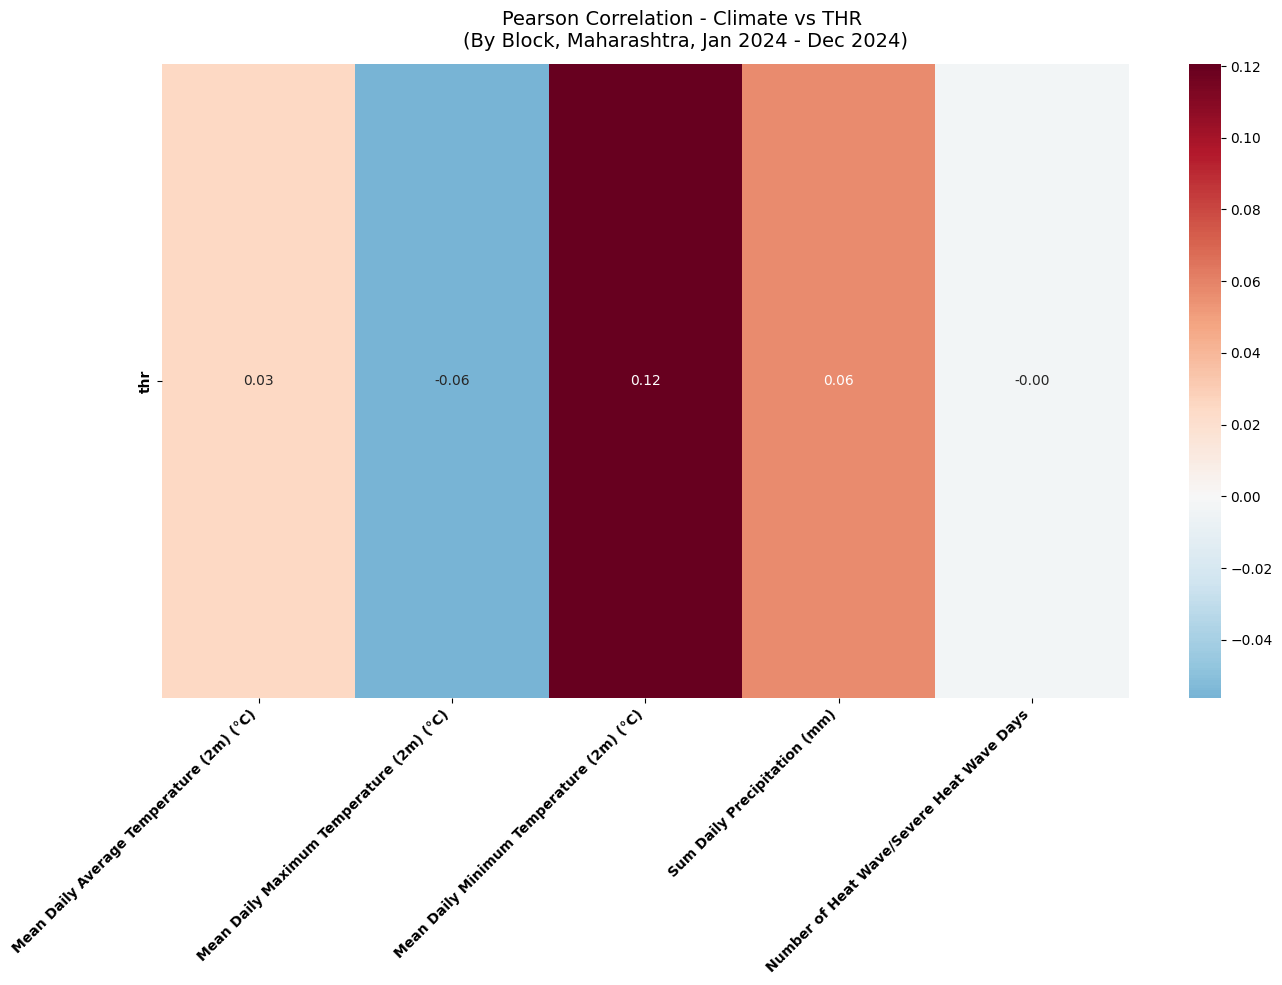


Top 3 correlated climate variables for THR:

thr:
  Mean Daily Minimum Temperature (2m) (°C): 0.121
  Sum Daily Precipitation (mm): 0.057
  Mean Daily Maximum Temperature (2m) (°C): -0.056



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Compute correlation matrix
# --------------------------

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter relevant time range
df=services_month_blocks.copy()

df.rename(columns={'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)': 'Sum Daily Precipitation (mm)'}, inplace=True)
# Define your variable groups
var = [
  'thr'
]

heat_vars = [
'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (mm)',
      'Number of Heat Wave/Severe Heat Wave Days'
]


# Compute correlation matrix
corr_df = df[var + heat_vars].corr(method='pearson')


# Extract submatrix: malnutrition (rows) x climate (columns)
corr_sub = corr_df.loc[var, heat_vars]


# Plot the heatmap

# Plot the heatmap
plt.figure(figsize=(14, 10))

ax = sns.heatmap(
    corr_sub,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt=".2f"
)

# Rotate x-tick labels by 45 degrees and align them
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

plt.suptitle("Pearson Correlation - Climate vs THR \n(By Block, Maharashtra, Jan 2024 - Dec 2024)", fontsize=14)
plt.tight_layout()
plt.show()

# --------------------------
# Print Top Correlations
# --------------------------

print("\nTop 3 correlated climate variables for THR:\n")

# Build a table to export


rows = []
for mal_var in var:
    top_corr = corr_sub.loc[mal_var].abs().sort_values(ascending=False).head(3)
    actual_corrs = corr_sub.loc[mal_var][top_corr.index]
    print(f"{mal_var}:")
    for var, val in actual_corrs.items():
        print(f"  {var}: {val:.3f}")
        rows.append({
            'Indicator': mal_var,
            'Top Climate Variable': var,
            'Correlation Coefficient': round(val, 3)
        })
    print()